In [0]:
install = True
%tensorflow_version 2.x

if install == True:
  !pip install talos
  !pip install livelossplot

TensorFlow 2.x selected.
     |████████████████████████████████| 61kB 2.0MB/s 
     |████████████████████████████████| 8.7MB 8.4MB/s 
     |████████████████████████████████| 109.2MB 26kB/s 
     |████████████████████████████████| 378kB 40.6MB/s 
     |████████████████████████████████| 26.6MB 1.5MB/s 
     |████████████████████████████████| 839kB 39.7MB/s 
     |████████████████████████████████| 3.2MB 30.0MB/s 
     |████████████████████████████████| 491kB 33.2MB/s 
  Created wheel for wrangle: filename=wrangle-0.6.7-cp36-none-any.whl size=49894 sha256=8644ffa4f7920444b49a5b332e0bb67098d146b8ed1d96b7938a54af0c04417a
  Stored in directory: /root/.cache/pip/wheels/bf/1b/50/d0403ce6ef269e364894da7b50db68db14c4ac62c577561e2d
  Created wheel for astetik: filename=astetik-1.9.9-cp36-none-any.whl size=56960 sha256=7125de7a3cbfdd3cec132c71f7c8937e6a4e32bdd0648c9f18c887c7949254fb
  Stored in directory: /root/.cache/pip/wheels/ae/70/21/c475cd079ec401dd6e1b9b1d42b4c38554ce12679bfb214aad
  Created 

In [0]:
import tensorflow as tf
from tensorflow import keras
import pydot
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
import talos
from talos import Evaluate
from talos import Predict
from talos import Reporting
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV

import time
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from __future__ import absolute_import, division, print_function, unicode_literals
print(tf.__version__)

1.14.0


## Connect to Google Drive




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Gather Data

In [0]:
# Access to the folder et see the files
# !ls "/content/drive/My Drive/IGE/Data/aws/D17_profiles.pkl"
# !ls "/content/drive/My Drive/IGE/Data/MAR/e86/MAR.pkl"

In [0]:
# Copy the file
!cp "/content/drive/My Drive/IGE/Data/aws/D17_observations.pkl" "D17_observations.pkl"
!cp "/content/drive/My Drive/IGE/Data/aws/D17_profiles.pkl" "D17_profiles.pkl"
!cp "/content/drive/My Drive/IGE/Data/MAR/e86/MAR.pkl" "MAR.pkl"
!cp "/content/drive/My Drive/IGE/NeuralNetwork_UV_T_RH_1_niveau_comparaison3" "NeuralNetwork_UV_T_RH_1_niveau_comparaison3"
!cp "/content/drive/My Drive/IGE/Data/aws/D17_total.pkl" "D17_total.pkl"

In [0]:
!cp "/content/drive/My Drive/IGE/Data/MAR/MAR_ERA5.pkl" "MAR_ERA5.pkl"
!cp "/content/drive/My Drive/IGE/Data/MAR/MAR_no_BS_ERA5.pkl" "MAR_no_BS_ERA5.pkl"

In [0]:
# Chech the file is downloaded
# !ls

# Check connection to GPU

In [0]:
'''
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
'''

"\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

# Load data

In [0]:
D17_observations = pd.read_pickle('D17_observations.pkl')
D17_profiles = pd.read_pickle('D17_profiles.pkl')
D17_total = pd.read_pickle('D17_total.pkl')
D17_profiles.index = D17_profiles.index - pd.DateOffset(minutes = 15)
MAR = pd.read_pickle('MAR_ERA5.pkl')
MAR_no_BS_ERA5 = pd.read_pickle('MAR_no_BS_ERA5.pkl')

# Preprocessing Data

In [0]:
# Temperatures in degrees
D17_observations['T2m'] = D17_observations['T2m'] + 273
D17_total['T1'] = D17_total['T1'] + 273
D17_total['T2'] = D17_total['T2'] + 273
D17_total['T3'] = D17_total['T3'] + 273
D17_total['T4'] = D17_total['T4'] + 273
D17_total['T5'] = D17_total['T5'] + 273
D17_total['T6'] = D17_total['T6'] + 273

# Delete wrong values
D17_total['RH1'][D17_total['RH1'] < 0] = np.NaN
D17_total['RH2'][D17_total['RH2'] < 0] = np.NaN
D17_total['RH3'][D17_total['RH3'] < 0] = np.NaN
D17_total['RH4'][D17_total['RH4'] < 0] = np.NaN
D17_total['RH5'][D17_total['RH5'] < 0] = np.NaN
D17_total['RH6'][D17_total['RH6'] < 0] = np.NaN

# Predict FC_2

In [0]:
Dataset_FC2 = D17_total[['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
       'U1', 'U2', 'U3', 'U4','FC2']].dropna()

X_train_FC2 = Dataset_FC2[['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
       'U1', 'U2', 'U3', 'U4']][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]
y_train_FC2 = Dataset_FC2['FC2'][(Dataset_FC2.index.year >= 2013) & (Dataset_FC2.index.year <= 2017)]

X_test_FC2 = Dataset_FC2[['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
       'U1', 'U2', 'U3', 'U4']][(Dataset_FC2.index.year == 2018)]
y_test_FC2 = Dataset_FC2['FC2'][(Dataset_FC2.index.year == 2018)]

Dataset_FC2 = D17_total[['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
       'U1', 'U2', 'U3', 'U4']].dropna()

X_predict_FC2 = Dataset_FC2[['FC1','RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
       'U1', 'U2', 'U3', 'U4']][(Dataset_FC2.index.year <= 2013)]

In [0]:
# Predict using a Random Forest
from sklearn.ensemble import RandomForestRegressor
rnd_clf = RandomForestRegressor(n_estimators=100) 
rnd_clf.fit(X_train_FC2, y_train_FC2) 
y_pred_rf = rnd_clf.predict(X_test_FC2)
from sklearn.metrics import mean_squared_error
print('RMSE FC2 prediction: \n')
mean_squared_error(y_test_FC2, y_pred_rf)**(0.5)

RMSE FC2 prediction: 



46.74344540499186

In [0]:
# Store prediction
y_pred2_FC2 = rnd_clf.predict(X_predict_FC2)

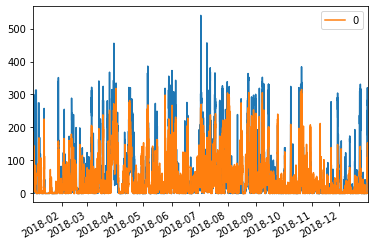

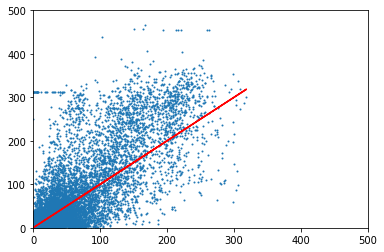

In [0]:
ax = plt.gca()
y_test_FC2.plot(ax=ax)
y_pred_rf = pd.DataFrame(y_pred_rf)
y_pred_rf.index = y_test_FC2.index
y_pred_rf.plot(ax=ax)

x = y_pred_rf.values
y = y_test_FC2.values

plt.figure()
ax = plt.gca()
ax.set_ylim(0,500)
ax.set_xlim(0,500)
plt.scatter(x,y, s=1)
plt.plot(x,x,color='red')


# Integrate FC2 to the working dataset and calculate FC

In [0]:
# Integrate FC2
y_pred2_FC2 = pd.DataFrame({'FC2':y_pred2_FC2})
y_pred2_FC2.index = X_predict_FC2.index
D17_total.update(y_pred2_FC2)

# Calculate FC
D17_total['hFC1'][D17_total['hFC1']<0] = 0
D17_total['hFC1'][D17_total['hFC1']>1] = 1

D17_total['FC_2'] = (D17_total['FC1']+D17_total['FC2'])/2
D17_total['FC_2'][D17_total['hFC1']<1] = (D17_total['FC1']*D17_total['hFC1']+D17_total['FC2']) / (D17_total['hFC1']+1)


# Delete constant values

In [0]:
# 25/12/2015

# FC = 314.48 for 7 hours on the 25th of December 2012
# D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)][40:90]
D17_observations['FC_2'][(D17_observations.index.year == 2015) & (D17_observations.index.month == 12) & (D17_observations.index.day >= 25) & (D17_observations.index.day <= 26)] = np.NaN
D17_total['FC_2'][(D17_total.index.year == 2015) & (D17_total.index.month == 12) & (D17_total.index.day >= 25) & (D17_total.index.day <= 26)] = np.NaN



# 06/01/2018

# FC = for 13 hours on the 3rd of December 2018
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 3) & (D17_total.index.day <= 4)] = np.NaN

# FC = 183.06 for 18 hours on the 6th of December 2018
# D17_observations['FC_2'][(D17_observations.index.year == 2018) & (D17_observations.index.month == 1) & (D17_observations.index.day >= 6) & (D17_observations.index.day <= 8)][30:90]
D17_total['FC_2'][(D17_total.index.year == 2018) & (D17_total.index.month == 1) & (D17_total.index.day >= 6) & (D17_total.index.day <= 8)] = np.NaN

# Insert snowfall as a predictive variable

In [0]:
D17_total['SF'] = MAR_no_BS_ERA5['SF']

# Select input variables

In [0]:
#D17_observations.columns
#D17_profiles.columns
#zU3 and zT4 for 2m levels
#D17_total.columns

In [0]:
#variables = ['SWU', 'SWD', 'LWU', 'LWD','U2m','T2m','RH2m','FC_2','zT', 'zU', 'U1', 'U2', 'zT1', 'zT2', 'zU1', 'zU2', 'T1',
#       'T2', 'RH1', 'RH2']
#variables = ['U2m','T2m','FC_2','zT', 'zU']
variables = ['T4', 'RH4', 'U4','zT4','zU4', 'SF', 'FC_2']
#variables = ['RH1', 'RH2', 'RH3', 'RH4', 'RH5', 'RH6',
#       'T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'U1', 'U2', 'U3', 'U4',
#       'zT1', 'zT2', 'zT3', 'zT4', 'zT5', 'zT6', 'zU1', 'zU2', 'zU3', 'zU4', 'SF', 'FC_2']

Dataset = D17_total[variables]
Dataset = Dataset.dropna()

#  Split training, validation, test

In [0]:
#X_train_full, X_test, y_train_full, y_test = train_test_split( D17_observations_1, D17_observations_2)
#X_train, X_valid, y_train, y_valid = train_test_split( X_train_full, y_train_full)

In [0]:
year_max = 2018

X_train = Dataset[variables[:-1]][(Dataset.index.year < year_max)].values
X_test = Dataset[variables[:-1]][(Dataset.index.year == year_max)].values

y_train = Dataset['FC_2'][(Dataset.index.year < year_max)].values
y_test = Dataset['FC_2'][(Dataset.index.year == year_max)].values

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)


# Scale

In [0]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid) 
X_test_scaled = scaler.transform(X_test)

# Neural Network

#### Model

In [0]:
# True for CV search, False for single model
cv_search_choice = True

def CV_search(n):

  ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to define if p should be the shape _____
    ____________________ of CV search or not_____________________
    _____________________________________________________________

  '''


  if n == True:
    p = {
        
        # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
        "architecture": [1],

        # For architecture 1 and 2
        "n_layers": [4],
        "n_neurons": [100],
         
        # Nadam, SGD RMSpop, Adagrad, Adadelta, Adam, Adamax, Nadam
        "optimizer": ["Nadam"],
         
        # Zeros, Ones, Constant, RandomNormal, RandomUniform, TruncatedNormal, VarianceScaling,
        # Orthogonal, Identity, lecun_uniform, glorot_normal, glorot_uniform, he_normal, lecun_normal, he_uniform
        'kernel_initializer': ["he_uniform", "lecun_normal"],
         
        # elu, softmax, selu, softplus, softsign, relu, tanh, sigmoid, hard_sigmoid, exponential, linear
        'activation': ["tanh"],
        "learning_rate": [0.001], 
        'batch_size': [30],
        'epochs': [5],
        'dropout': [0],
        "loss": ["mean_squared_error"],
        "fit": [True]}



  if n == False:
    p = {
        
        # 1 = Classic, 2= Concatenate, 3 = BatchNormalization
        "architecture": 1, 

        # For architecture 1 and 2
        "n_layers": 4,
        "n_neurons": 300,
        "optimizer": "Nadam",
        'kernel_initializer': "lecun_uniform",
        'activation': "tanh",
        "learning_rate":0.01, 
        'batch_size': 20,
        'epochs': 100,
        'dropout': 0,
        "loss": "mean_squared_error",
        "fit": False}


  return(p)

p = CV_search(cv_search_choice)

In [0]:
def choose_optimizer(name, learning_rate):

  ''' 
    _____________________________________________________________
    _____________________________________________________________
    _______ Function use to CV search the best optimizer ________
    __________Input = Name, Leaning rate_________________________
    _____________________________________________________________
  '''


  if name == "SGD":
    return(keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.0, nesterov=False))
  
  if name == "RMSprop":
    return(keras.optimizers.RMSprop(learning_rate=learning_rate, rho=0.9))

  if name == "Adagrad":
    return(keras.optimizers.Adagrad(learning_rate=learning_rate))

  if name == "Adadelta":
    return(keras.optimizers.Adadelta(learning_rate=learning_rate, rho=0.95))

  if name == "Adam":
    return(keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False))

  if name == "Adamax":
    return(keras.optimizers.Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

  if name == "Nadam":
    return(keras.optimizers.Nadam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999))

In [0]:
def build_model(X_train, y_train, X_valid_scaled, y_valid, params):
    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Classic        ________________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 1:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        options = {"input_shape": X_train.shape[1:]} 

      #______________   Adding layers   ____________________________
        for layer in range(params['n_layers']):
            model.add(keras.layers.Dense(params['n_neurons'], 
                                      activation= params['activation'],
                                      kernel_initializer=params['kernel_initializer'], 
                                      **options)) 
            options = {}

        #______________   Output layer   _____________________________
        model.add(keras.layers.Dense(1,
                                  kernel_initializer=params['kernel_initializer'],
                                  **options)) 
      
        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)
    
    





    
    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________     Concatenate        ____________________
    _____________________________________________________________
    _____________________________________________________________
    '''


    if params["architecture"] == 2:
        
        #______________   Building model   ___________________________
        model = keras.models.Sequential() 
        input = keras.layers.Input(shape=X_train_scaled.shape[1:]) 

        #______________   Adding layers   ____________________________
        hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(input) 
        for layer in range(params['n_layers']-1): 
            hidden = keras.layers.Dense(params['n_neurons'], activation=params['activation'], kernel_initializer=params['kernel_initializer'])(hidden)
      
        #______________   Concatenate   ____________________________
        concat = keras.layers.Concatenate()([input, hidden]) 

        #______________   Output layer   _____________________________
        output = keras.layers.Dense(1)(concat) 
        model = keras.models.Model(inputs=[input], outputs=[output])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)











    ''' 
    _____________________________________________________________
    _____________________________________________________________
    _________________  Batch Normalization   ____________________
    ___for deeper networks it can make a tremendous difference___
    _____________________________________________________________
    '''
    
    
    if params["architecture"] == 3:
      
      #______________   Building model   ___________________________
        model = keras.models.Sequential([ 
        keras.layers.Flatten(input_shape=X_train_scaled.shape[1:]),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(300, activation=params['activation'], kernel_initializer=params['kernel_initializer']),
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(200, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(100, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(5, activation=params['activation'], kernel_initializer=params['kernel_initializer']), 
        keras.layers.BatchNormalization(), 
        keras.layers.Dense(1)])

        #______________   Choosing optimizer   _______________________
        optimizer = choose_optimizer(params["optimizer"], params["learning_rate"])

        #__________________   Compiling   ____________________________
        model.compile(loss=params["loss"], optimizer=optimizer)

    if params["fit"] == True:

      history = model.fit(X_train, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=params['batch_size'],epochs=params['epochs'],verbose=0)
      return history, model

    else:
      return 0, model

In [0]:
if cv_search_choice == False:
  start_time = time.time()
  '''
  # Distribution strategies
  tf.config.experimental_connect_to_host('grpc://' + os.environ['COLAB_TPU_ADDR'])
  resolver = tf.distribute.cluster_resolver.TPUClusterResolver('grpc://' + os.environ['COLAB_TPU_ADDR'])
  tf.tpu.experimental.initialize_tpu_system(resolver)
  strategy = tf.distribute.experimental.TPUStrategy(resolver) 
  
  
  print("--- %s seconds for building model" % (time.time() - start_time))
  start_time = time.time()
  model.fit(X_train_scaled,
          epochs=5,
          validation_data=[X_valid_scaled, y_valid],
          batch_size=5)
  '''
  [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, p)
  from livelossplot.keras import PlotLossesCallback
  model.fit(X_train_scaled, y_train, validation_data=[X_valid_scaled, y_valid],batch_size=p['batch_size'],epochs=p['epochs'], callbacks=[PlotLossesCallback()])
  
  print("--- %s seconds for fitting model" % (time.time() - start_time))
else:

  t = talos.Scan(x=X_train_scaled, y=y_train, params=p, model=build_model, experiment_name='DNN_snow_mass_fluxes', print_params=True)
  talos_data = t.data.sort_values(by=['val_loss'])
  print('\n\n')
  print(talos_data)

  # Reporting
  print('\n\n')
  experiment_log_list = !ls -lhtr DNN_snow_mass_fluxes
  experiment_log = experiment_log_list[-1].split()[-1]
  r = Reporting('DNN_snow_mass_fluxes/'+experiment_log)
  print('\n\n')
  print("Number of rounds it took to find best model: {}".format(r.rounds2high('val_loss')))
  print('\n\n')
  print('Best model parameters: ')
  best_model_parameters = pd.DataFrame(talos_data.iloc[0,:]).transpose()
  print(pd.DataFrame(talos_data.iloc[0,:]).transpose())

  # Exporting best model
  best_model_parameters_export = best_model_parameters.iloc[0,:].to_dict()
  best_model_parameters = best_model_parameters.iloc[0,:].to_dict()
  best_model_parameters.update({'fit' : True})
  best_model_parameters_export.update({'fit' : False})
  [history, model] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)
  [history_export, best_dnn] = build_model(X_train_scaled, y_train, X_valid_scaled, y_valid, best_model_parameters)

  0%|          | 0/2 [00:00<?, ?it/s]

{'activation': 'tanh', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 5, 'fit': True, 'kernel_initializer': 'he_uniform', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}


 50%|█████     | 1/2 [00:17<00:17, 17.42s/it]

{'activation': 'tanh', 'architecture': 1, 'batch_size': 30, 'dropout': 0, 'epochs': 5, 'fit': True, 'kernel_initializer': 'lecun_normal', 'learning_rate': 0.001, 'loss': 'mean_squared_error', 'n_layers': 4, 'n_neurons': 100, 'optimizer': 'Nadam'}


100%|██████████| 2/2 [00:34<00:00, 17.23s/it]




   round_epochs        loss    val_loss  ... n_layers  n_neurons  optimizer
0             5  751.194191  726.245828  ...        4        100      Nadam
1             5  764.451958  727.068307  ...        4        100      Nadam

[2 rows x 15 columns]








Number of rounds it took to find best model: 1



Best model parameters: 
  round_epochs     loss val_loss  ... n_layers n_neurons optimizer
0            5  751.194  726.246  ...        4       100     Nadam

[1 rows x 15 columns]


#### Evaluation

In [0]:
y_MAR = MAR['FC'][MAR.index.isin(D17_observations.index)]
y_obs = D17_observations['FC_2'][D17_observations.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs)**2 ).mean()
print("RMSE between MAR and observations (all dataset): {}".format(round(RMSE_MAR)))
'''
y_MAR = MAR['FC'][MAR.index.isin(y_test.index)]
y_obs = y_test[y_test.index.isin(y_MAR.index)]
RMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()
print("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))
'''

RMSE between MAR and observations (all dataset): 32


'\ny_MAR = MAR[\'FC\'][MAR.index.isin(y_test.index)]\ny_obs = y_test[y_test.index.isin(y_MAR.index)]\nRMSE_MAR = np.sqrt( (y_MAR - y_obs.iloc[:,0])**2 ).mean()\nprint("RMSE between MAR and observations (specific period): {}".format(round(RMSE_MAR)))\n'

In [0]:
mse_test = model.evaluate(X_test_scaled , y_test)
rmse_test = (mse_test)**(1/2)
print("RMSE DNN model on test data: {}".format(round(rmse_test)))

17173/17173 [==============================] - 0s 21us/sample - loss: 2884.6056
RMSE DNN model on test data: 54.0


In [0]:
print("Ration of validation dataset on test dataset exoressed in %: {}".format(round(100 * len(y_valid)/len(y_test),2)))

Ration of validation dataset on test dataset exoressed in %: 0.41


#### Prediction

In [0]:
X_new = X_test_scaled

# pretend these are new instances 
y_pred = model.predict(X_new)

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0

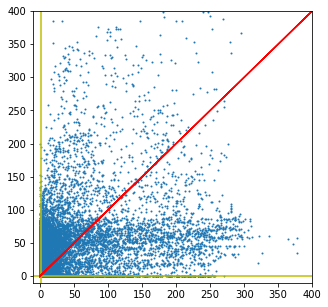

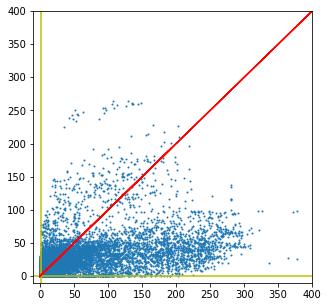

In [0]:
if year_max < 2019:
  plt.figure(1, figsize=(5,5))
  y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_test_MAR, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

  plt.figure(2, figsize=(5,5))
  plt.plot(y_test,y_test,c='red')
  plt.scatter(y_test, y_pred, s=1)
  ax = plt.gca()
  ax.set_xlim(-10,400)
  ax.set_ylim(-10,400)
  plt.hlines(1,-10,400,color='y')
  plt.vlines(1,-10,400,color='y')

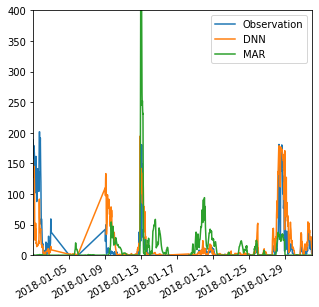

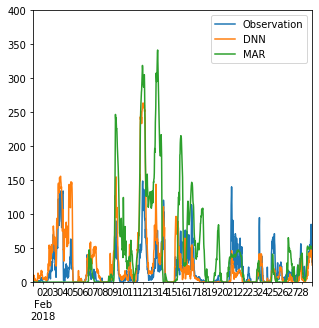

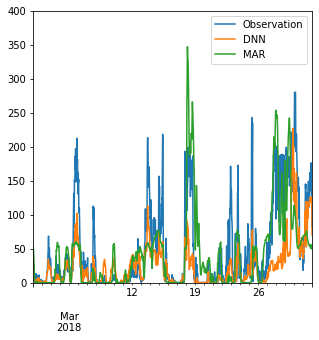

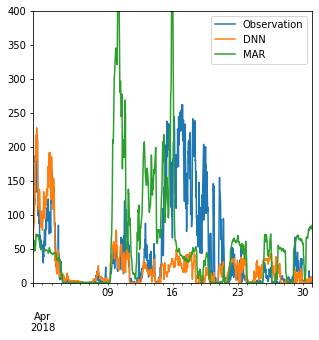

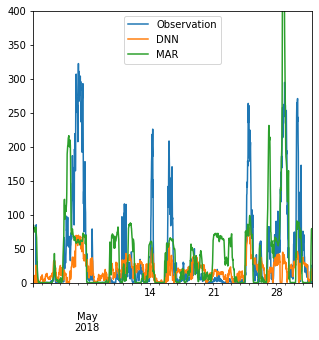

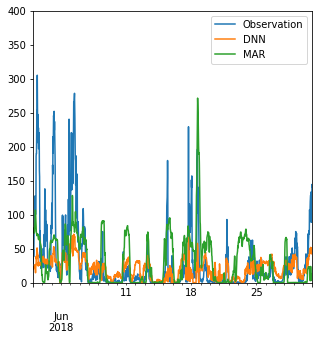

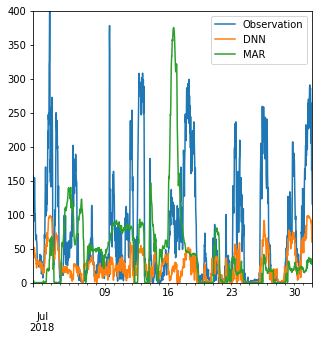

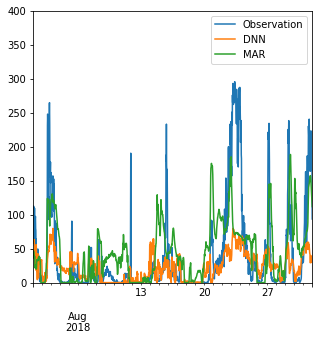

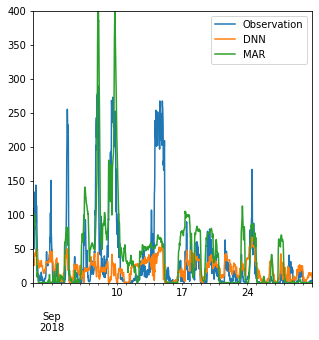

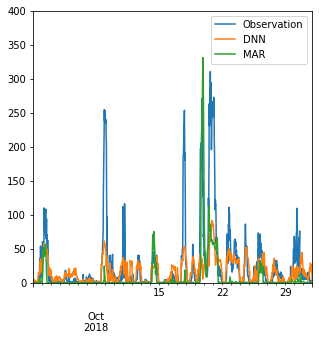

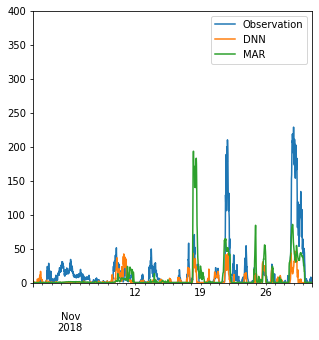

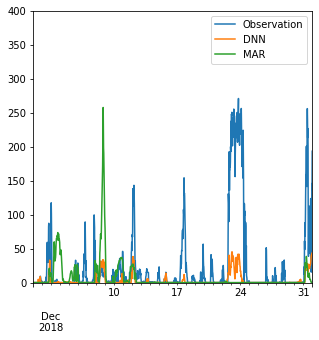

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'DNN', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

In [0]:
print(y_pred.mean()-y_test.mean() - y_pred.min())
print(y_test_MAR.mean() - y_test.mean())
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
#print(pd.concat([Dataset['U1'][Dataset.index.year == year_max], y_test], axis=1).corr().iloc[0,1])

pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

0   -15.723869
dtype: float64
0   -2.867404
dtype: float64
0    18.588564
dtype: float32
0    34.312433
dtype: float64
31.445028889767627


Correlation coefficient: 
0.5282847595279916


0.4031625539212806

# Random Forest

## Random Hyperparameter Grid

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 2)]

# Number of features to consider at every split
max_features = ['auto']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(90, 100, num = 2)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1]

# Method of selecting samples for training each tree
bootstrap = [True]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True],
 'max_depth': [90, 100, None],
 'max_features': ['auto'],
 'min_samples_leaf': [1],
 'min_samples_split': [10],
 'n_estimators': [100, 500]}


In [0]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 2, verbose=10, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 6 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.8min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.1min remaining:   41.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.9min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [0]:
#best parameters from fitting the random search
rf_best_param = rf_random.best_params_
rf_best_param

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 500}

## Grid Search with Cross Validation

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [rf_best_param['bootstrap']],
    'max_depth': [rf_best_param['max_depth']],
    'max_features': [rf_best_param['max_features']],
    'min_samples_leaf': [int(x) for x in np.linspace(rf_best_param['min_samples_leaf'], rf_best_param['min_samples_leaf']+2, num = 1)],
    'min_samples_split': [int(x) for x in np.linspace(rf_best_param['min_samples_split'], rf_best_param['min_samples_split']+2, num = 1)],
    'n_estimators': [int(x) for x in np.linspace(rf_best_param['n_estimators'], rf_best_param['n_estimators']+500, num = 4)]}
print(param_grid)

{'bootstrap': [True], 'max_depth': [None], 'max_features': ['auto'], 'min_samples_leaf': [1], 'min_samples_split': [10], 'n_estimators': [500, 666, 833, 1000]}


In [0]:
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2, n_jobs = -1, verbose = 10)
# Fit the random search model
grid_search.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  1.5min remaining:  4.5min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:  2.0min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:  3.9min remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:  3.9min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  4.6min finished


GridSearchCV(cv=2, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

## Best Random Forest model

In [0]:
best_param_rand_forest = grid_search.best_params_
best_param_rand_forest

{'bootstrap': True,
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 833}

##Predicting on test value with Random Forest

In [0]:
rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators'],
                                n_jobs=-1)
rnd_clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=10, min_weight_fraction_leaf=0.0,
                      n_estimators=833, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [0]:
y_pred_rf = rnd_clf.predict(X_test)
y_pred = y_pred_rf
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0

In [0]:
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

49.881675415429136

RMSE MAR: 

62.42976165678927


Biais corrigé: 
0   -16.504297
dtype: float64

Biais MAR: 
0   -2.867404
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    17.808135
dtype: float64
0    34.312433
dtype: float64
31.445028889767627


Correlation coefficient: 
nan


0.4031625539212806

T4 0.05793386526820827
RH4 0.08062462895502179
U4 0.705770513692162
zT4 0.097444798370371
zU4 0.026954504329393135
SF 0.031271689384843836


([<matplotlib.axis.XTick at 0x7fe36fa51eb8>,
 <a list of 6 Text xticklabel objects>)

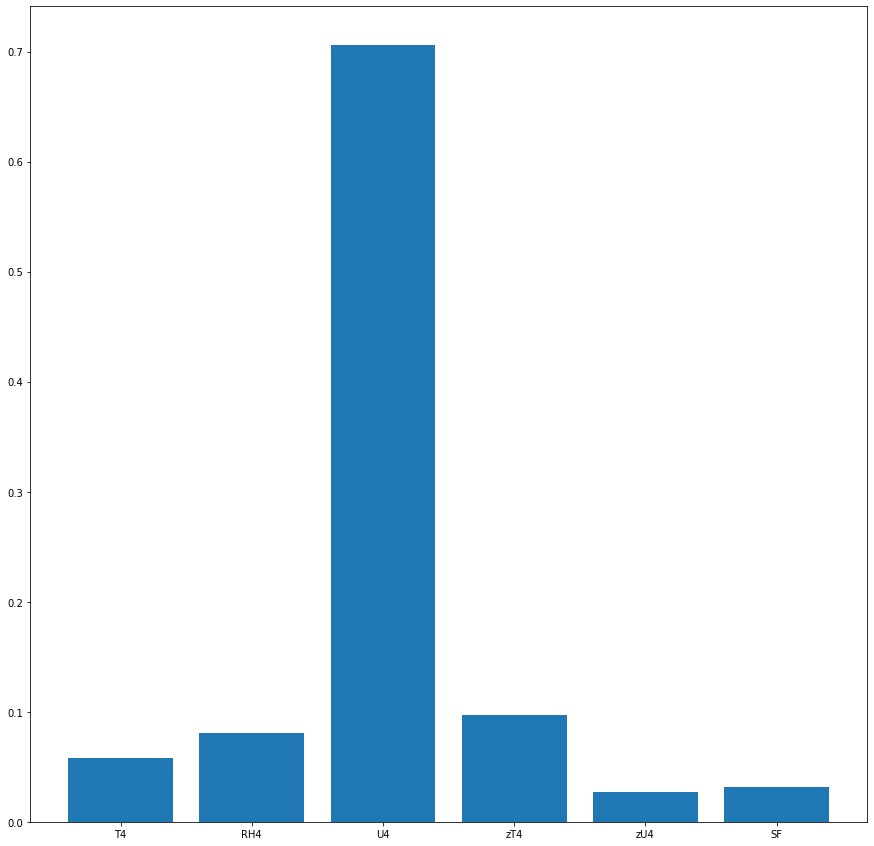

In [0]:
for name, score in zip(Dataset.columns, rnd_clf.feature_importances_):
  print(name, score)

plt.figure(figsize=(15,15))
ind = np.arange(len(rnd_clf.feature_importances_))
plt.bar(ind, rnd_clf.feature_importances_)
plt.xticks(ind, list(Dataset.columns))

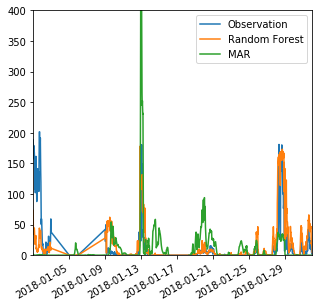

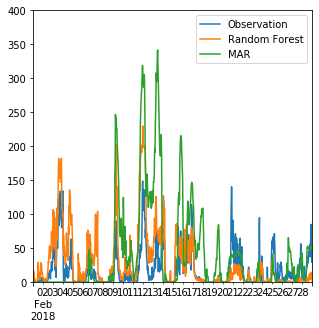

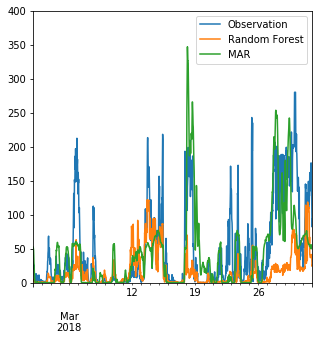

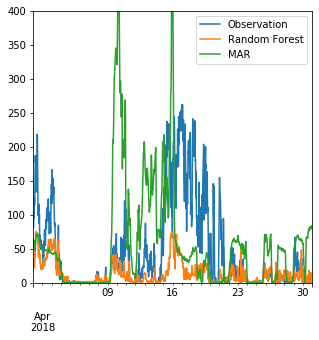

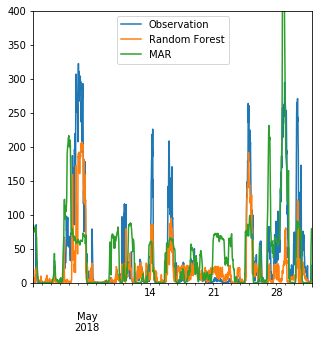

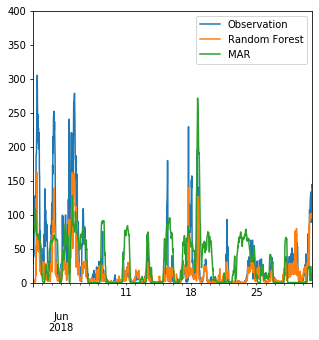

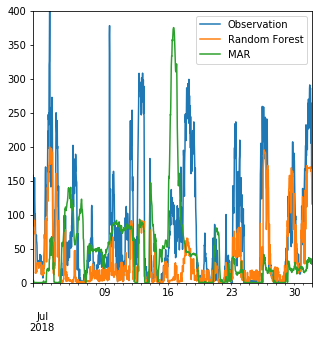

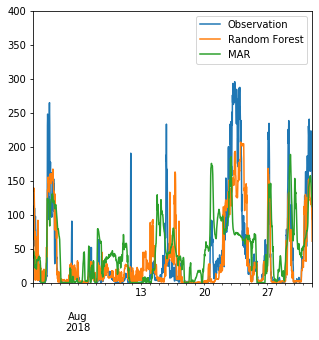

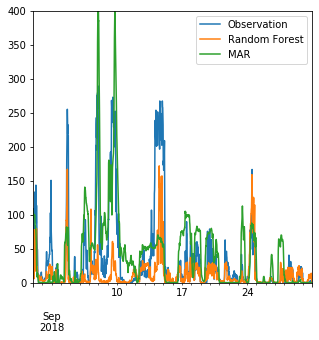

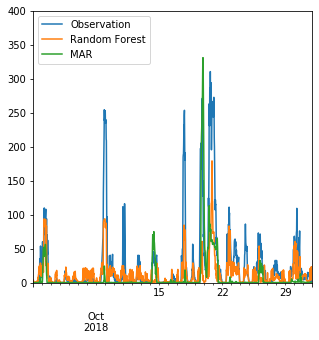

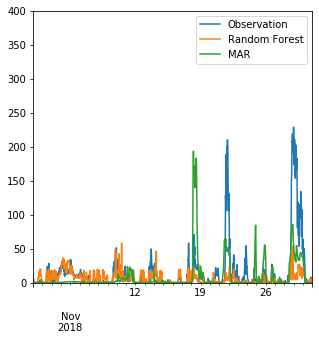

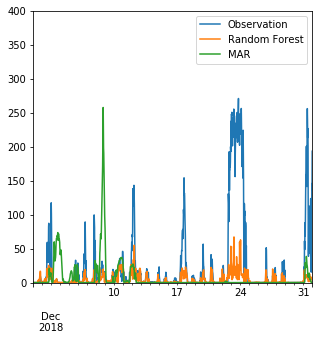

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    ax.legend(('Observation', 'Random Forest', 'MAR'))
    ax.set_ylim(0,400)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Lasso Regression


In [0]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=0.3)
lasso_reg.fit(X_train, y_train)
y_pred = lasso_reg.predict(X_test)

In [0]:
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('Biais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

37.398504288084396
Biais corrigé: 
0    4.546031
dtype: float64

Biais MAR: 
0   -2.867404
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    38.858464
dtype: float64
0    34.312433
dtype: float64
31.445028889767627


Correlation coefficient: 
nan


0.4031625539212806

([<matplotlib.axis.XTick at 0x7fe363928f28>,
 <a list of 6 Text xticklabel objects>)

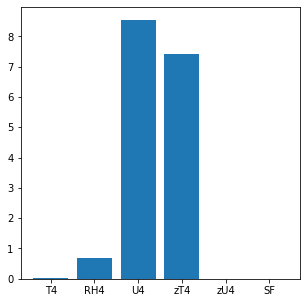

In [0]:
plt.figure(figsize=(5,5))
ind = np.arange(len(lasso_reg.coef_))
plt.bar(ind, lasso_reg.coef_)
plt.xticks(ind, list(Dataset.columns))

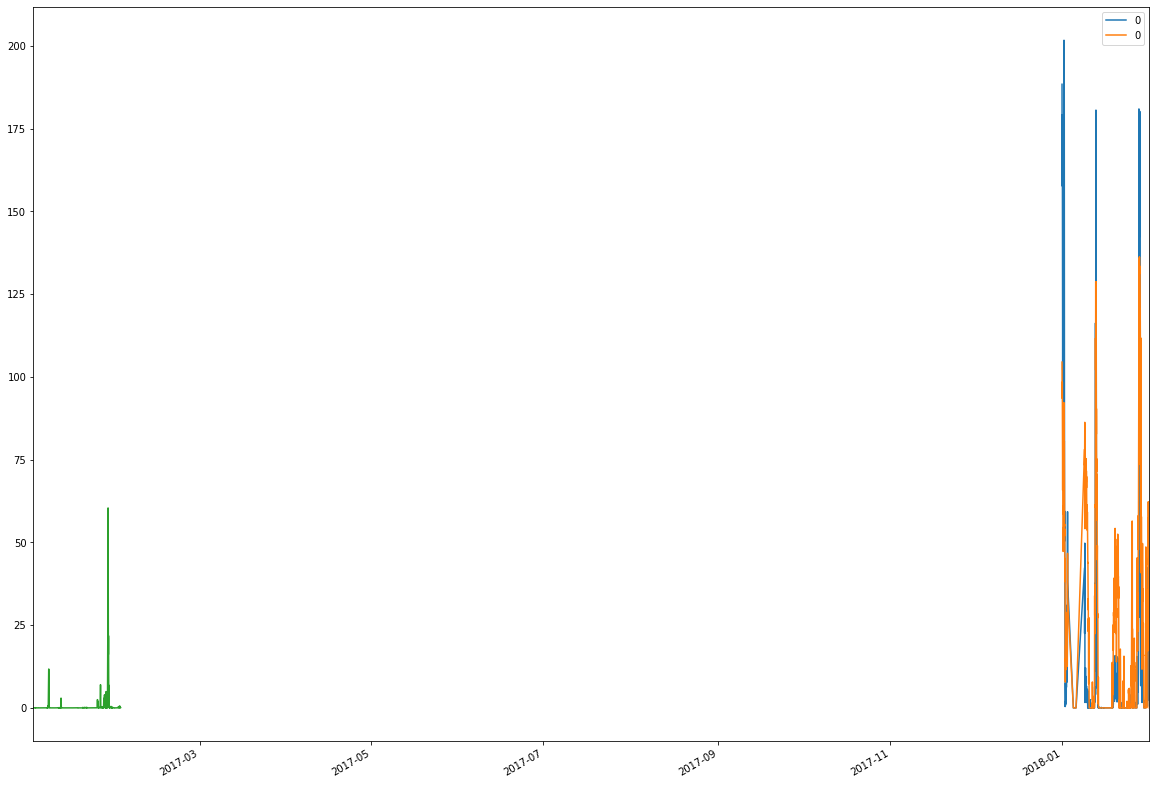

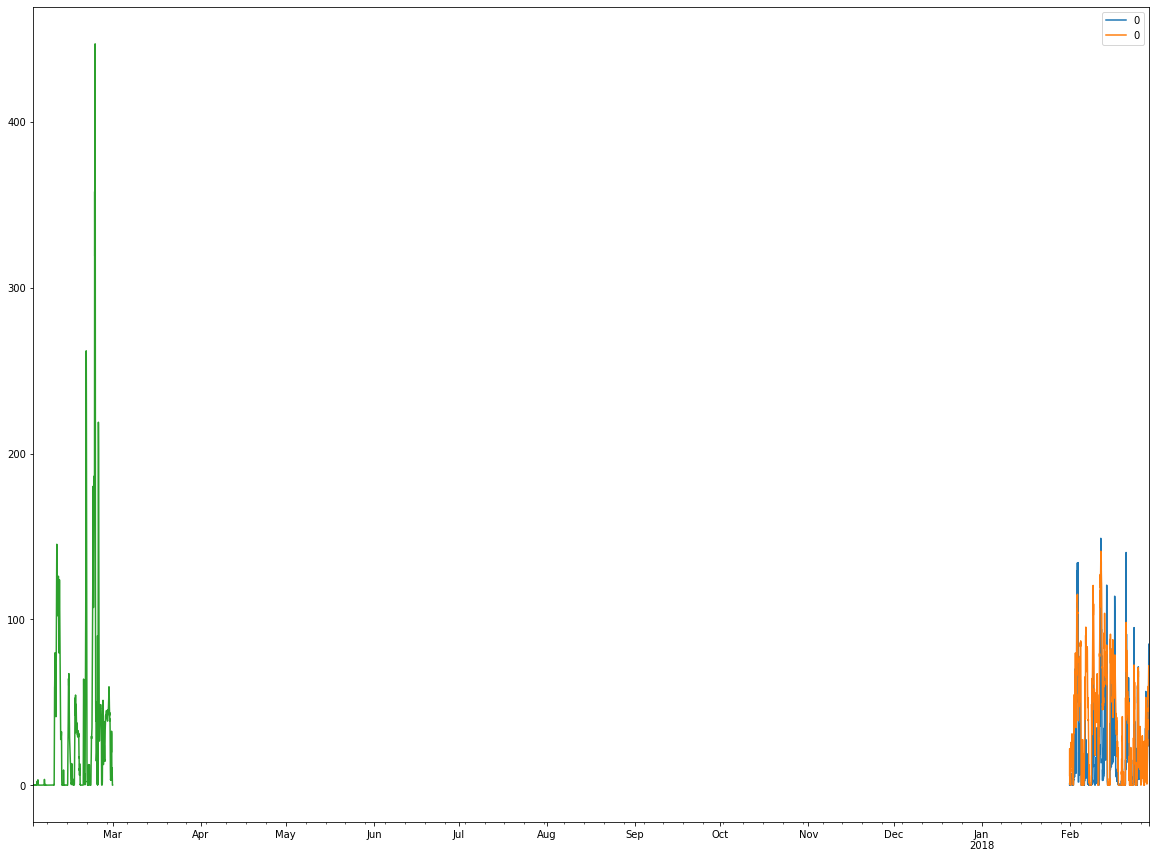

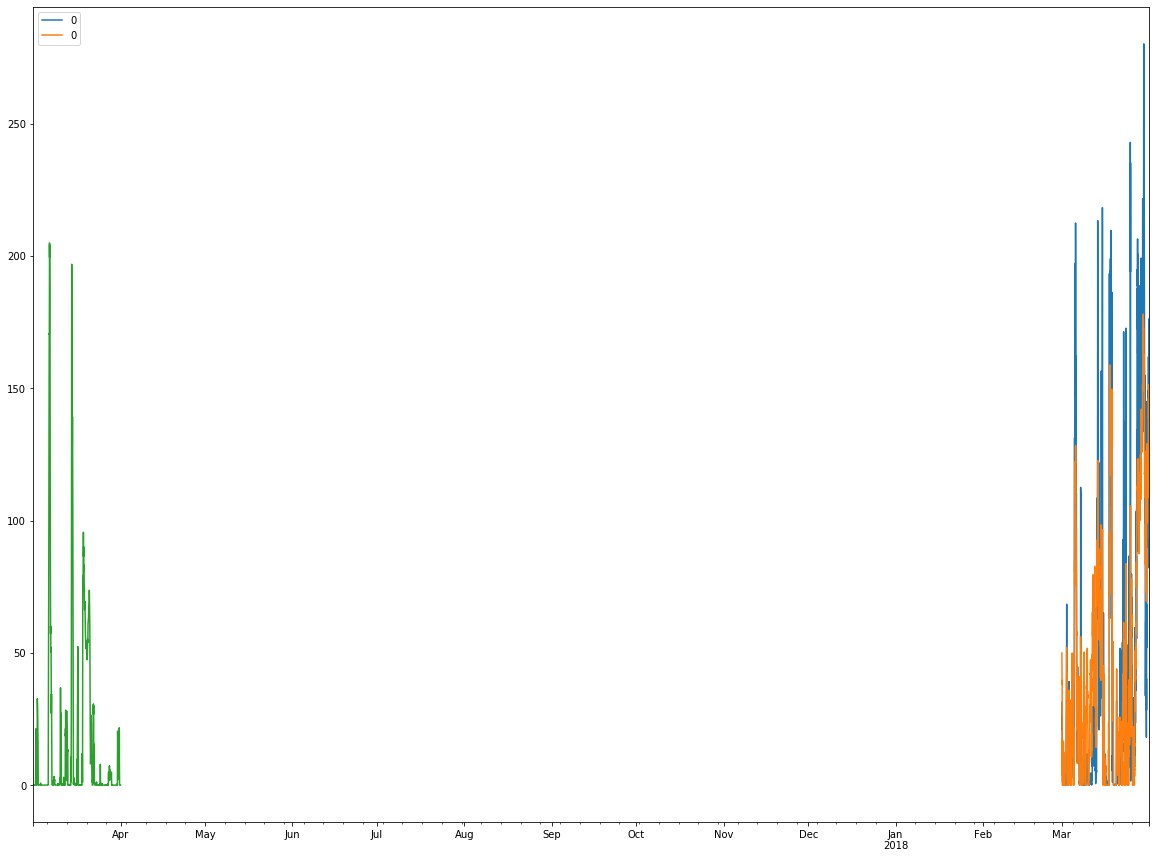

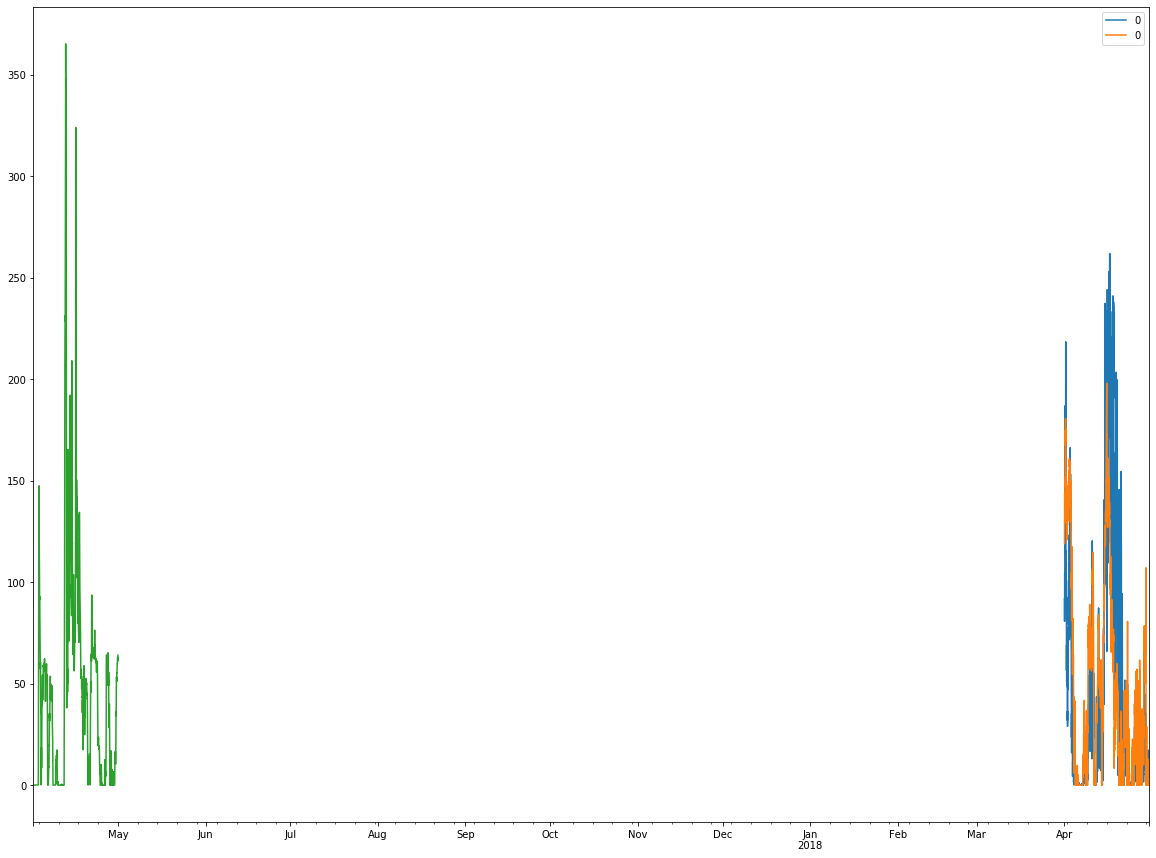

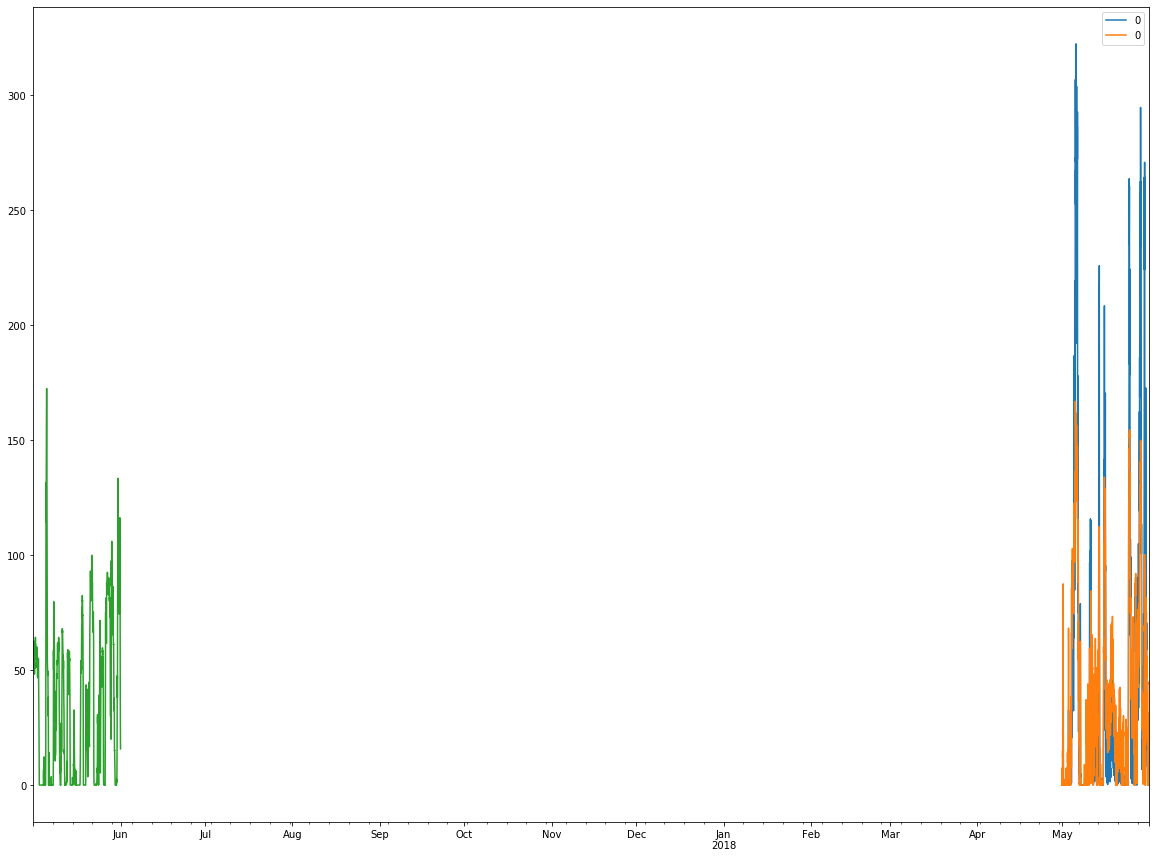

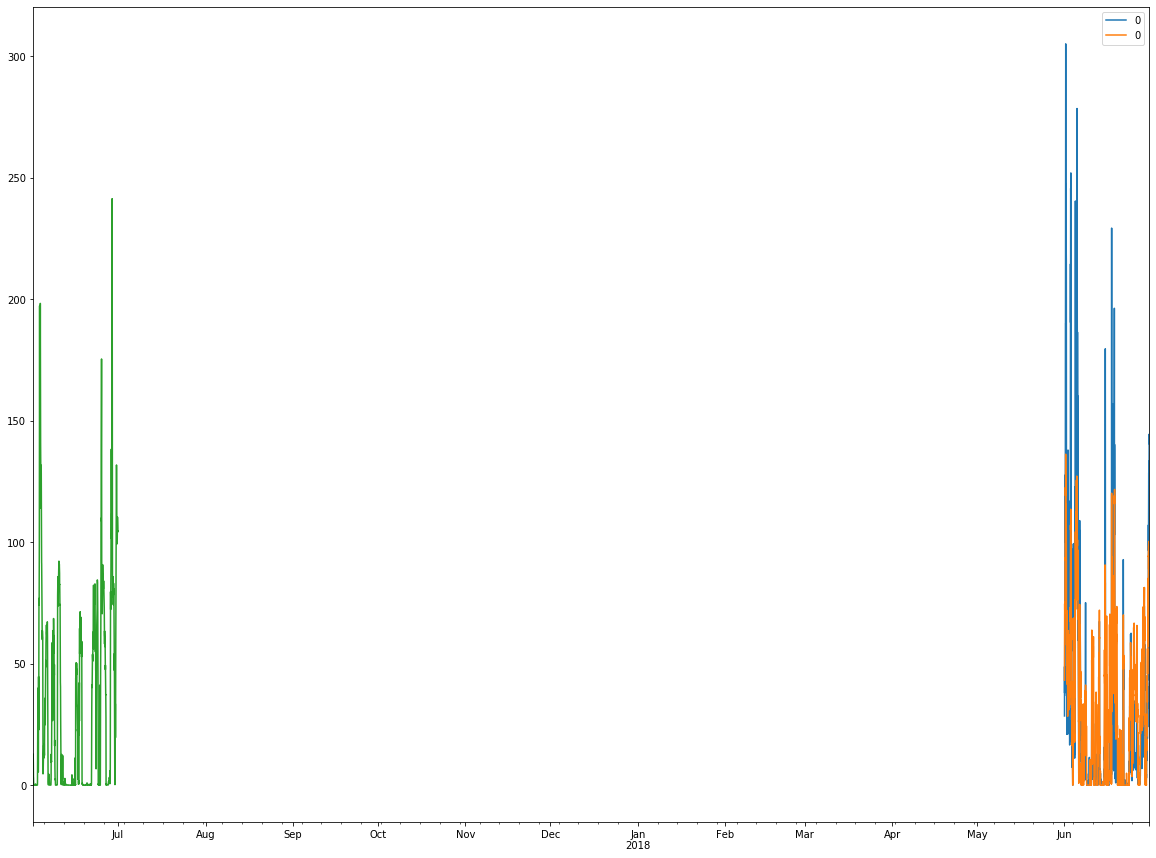

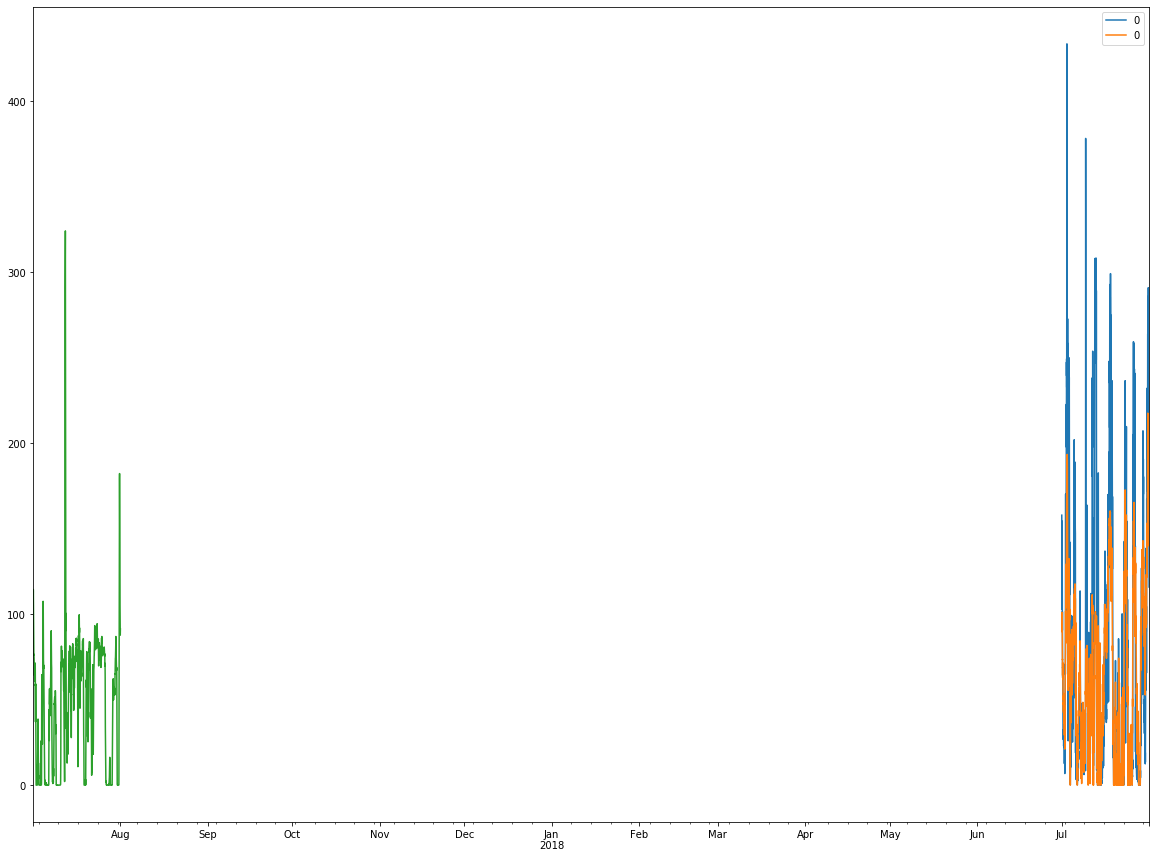

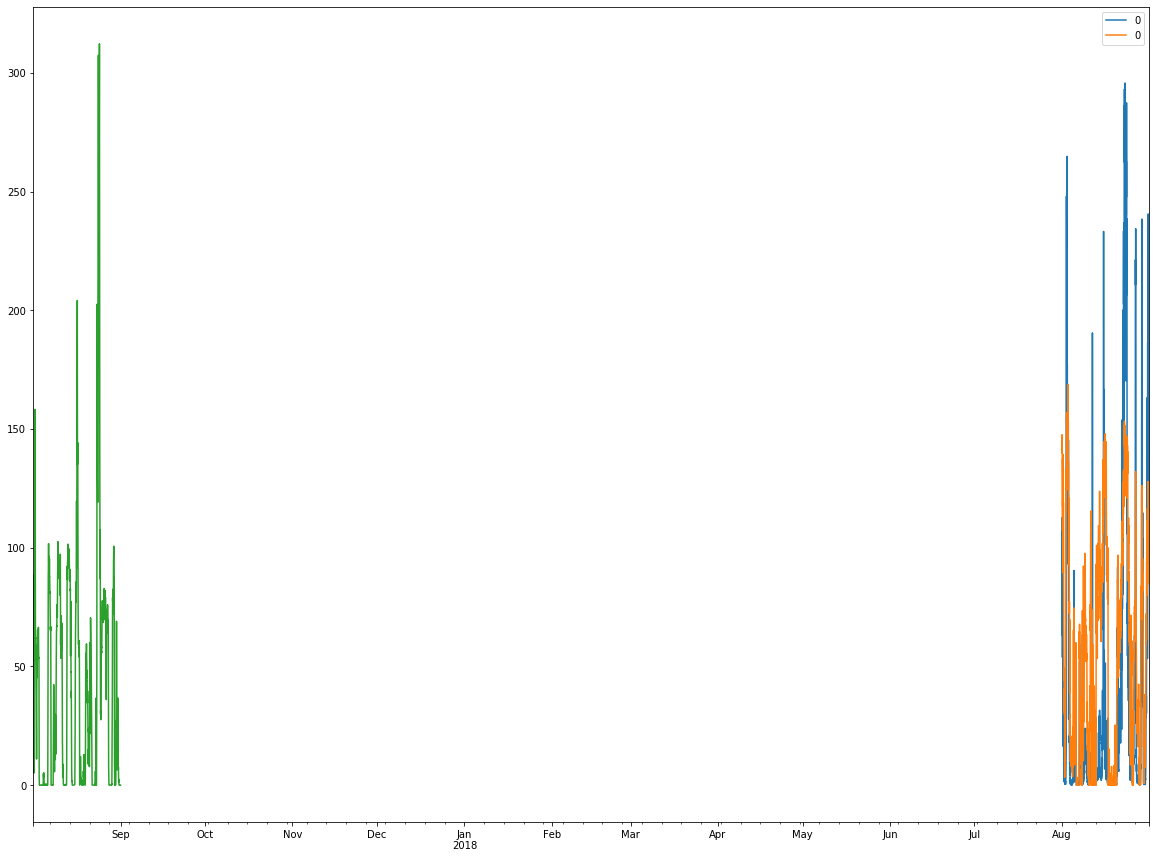

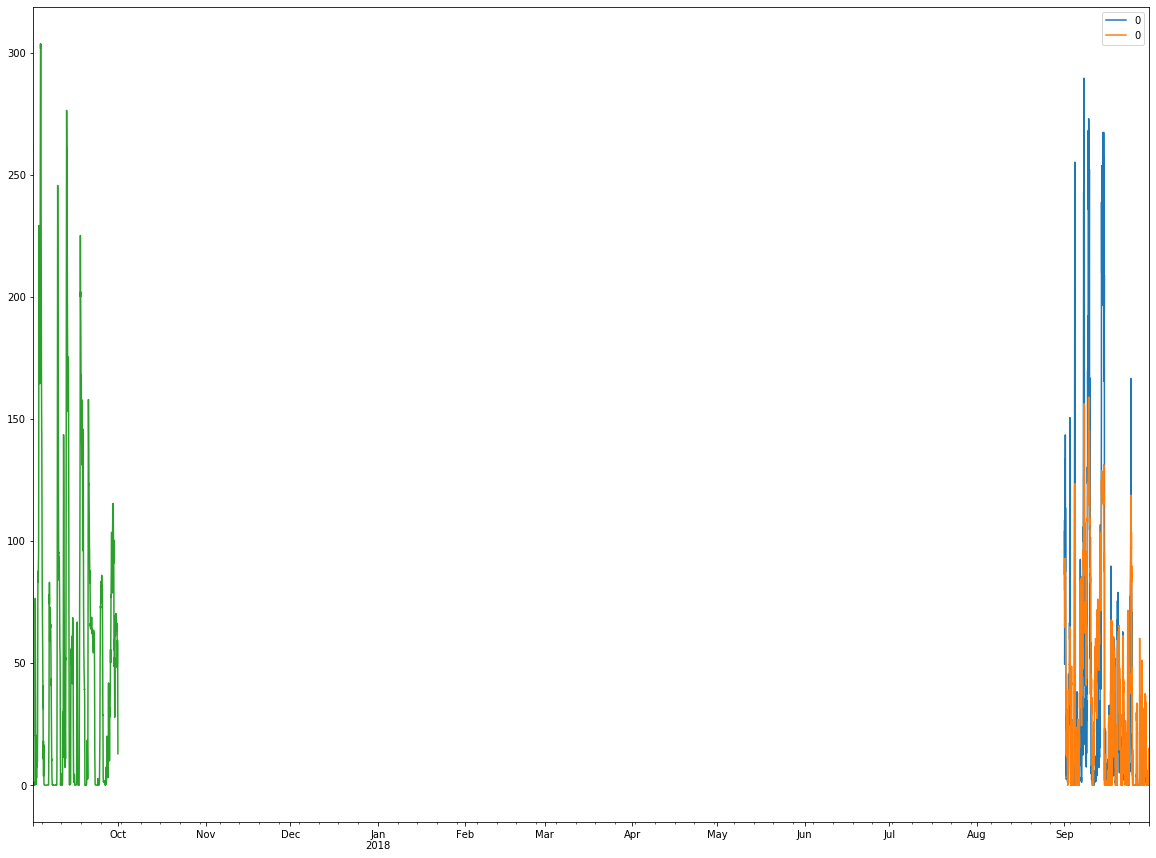

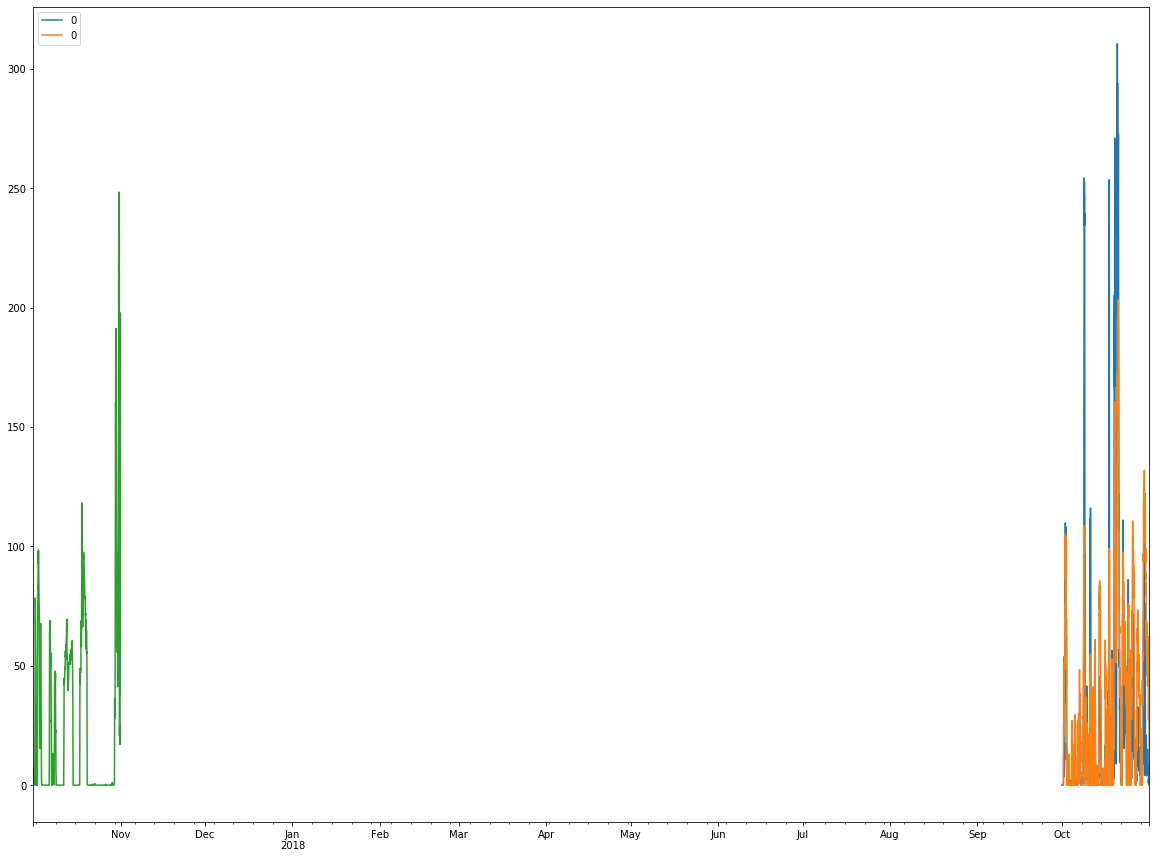

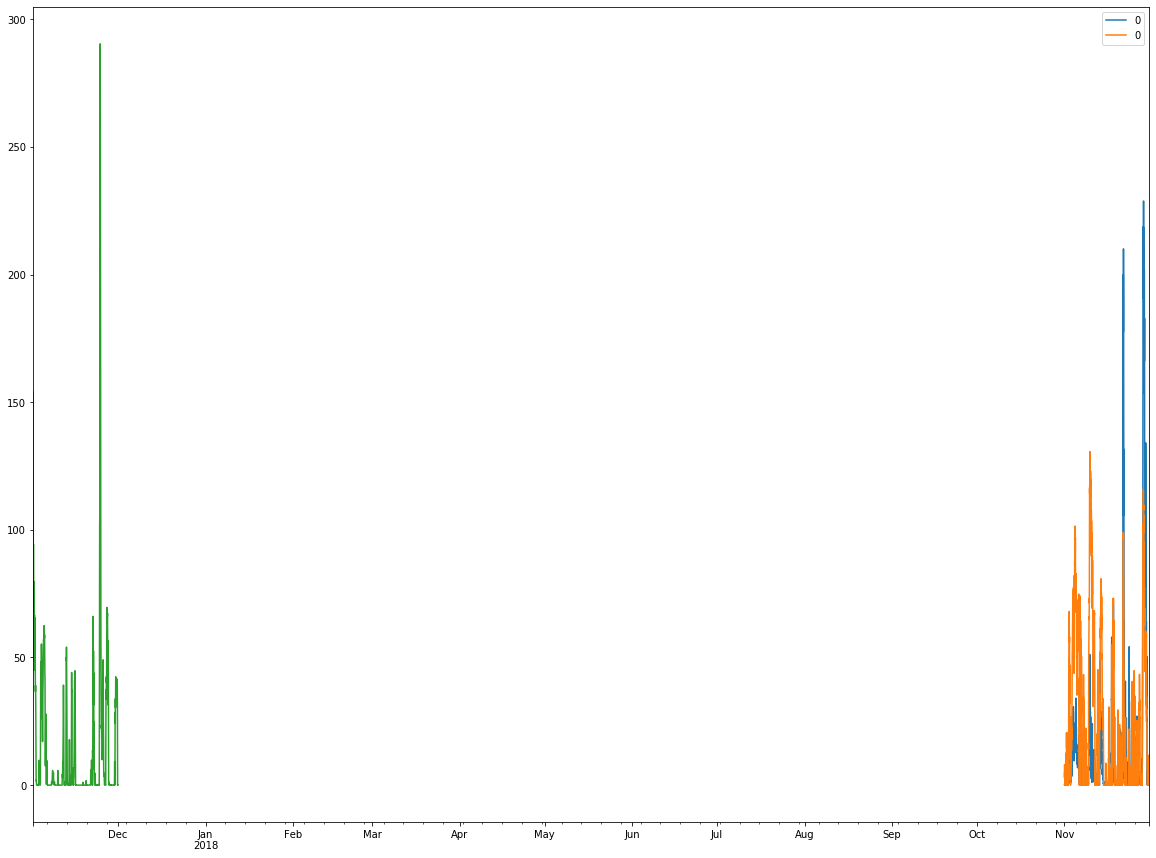

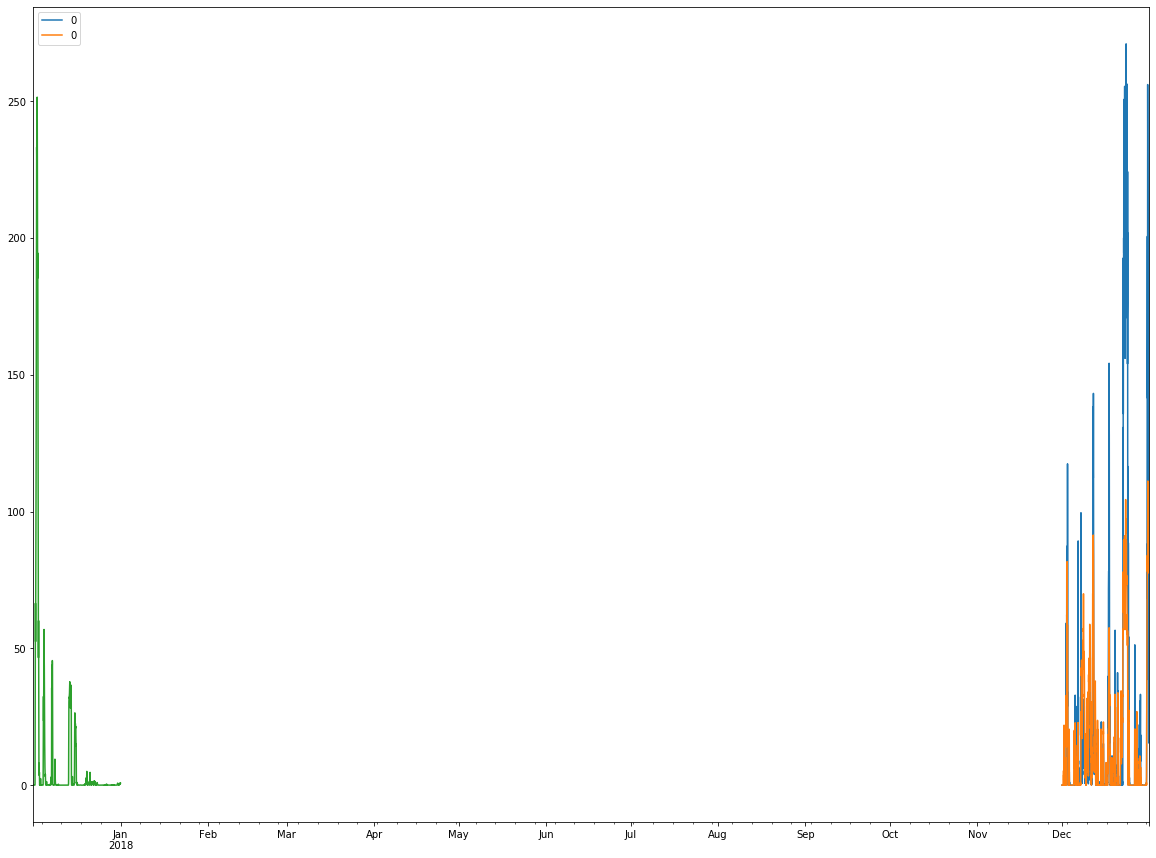

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == 2017) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Polynomial regression

In [0]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2, include_bias=False) 
X_poly = poly_features.fit_transform(X_train)

In [0]:
#from sklearn.linear_model import LinearRegression
#lin_reg = LinearRegression() 
#lin_reg.fit(X_poly, y_train)
poly_reg = Lasso(alpha=0.3)
poly_reg.fit(X_poly, y_train)

Lasso(alpha=0.3, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [0]:
X_test_poly = poly_features.fit_transform(X_test)
#y_pred = lin_reg.predict(X_test_poly)

y_pred = poly_reg.predict(X_test_poly)

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)**(0.5)

36.85861704860461

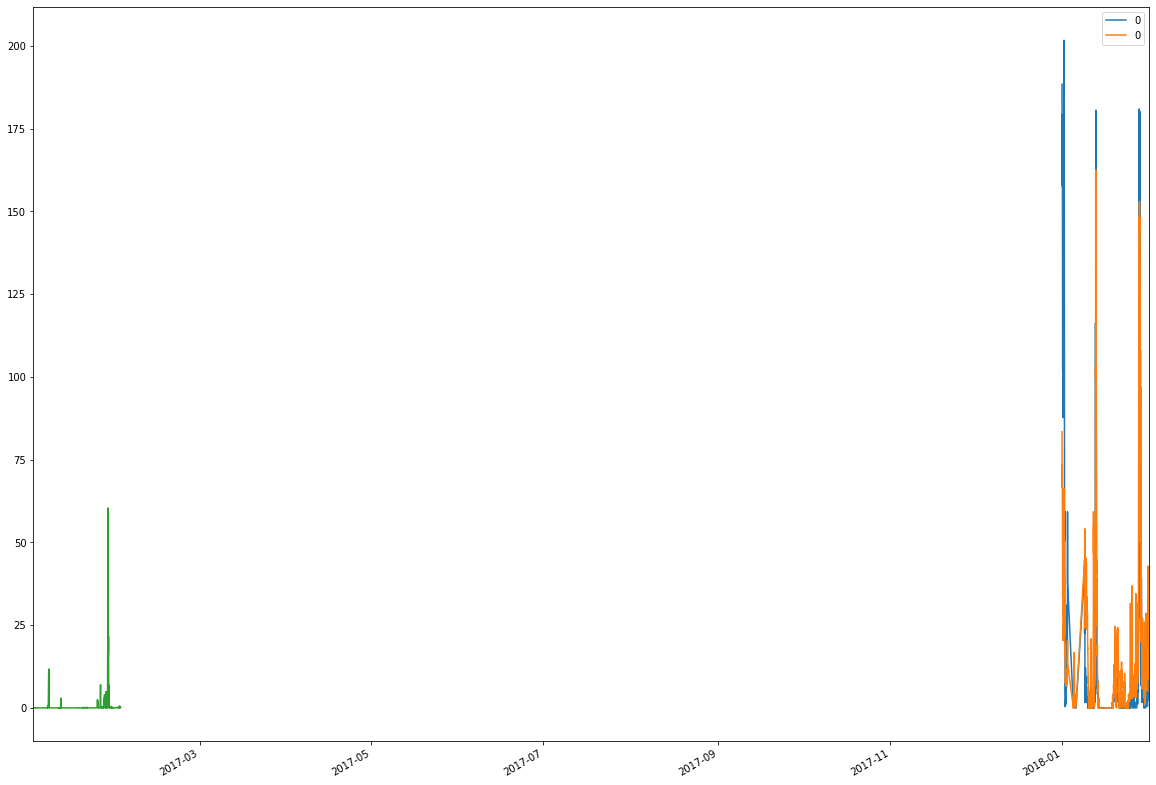

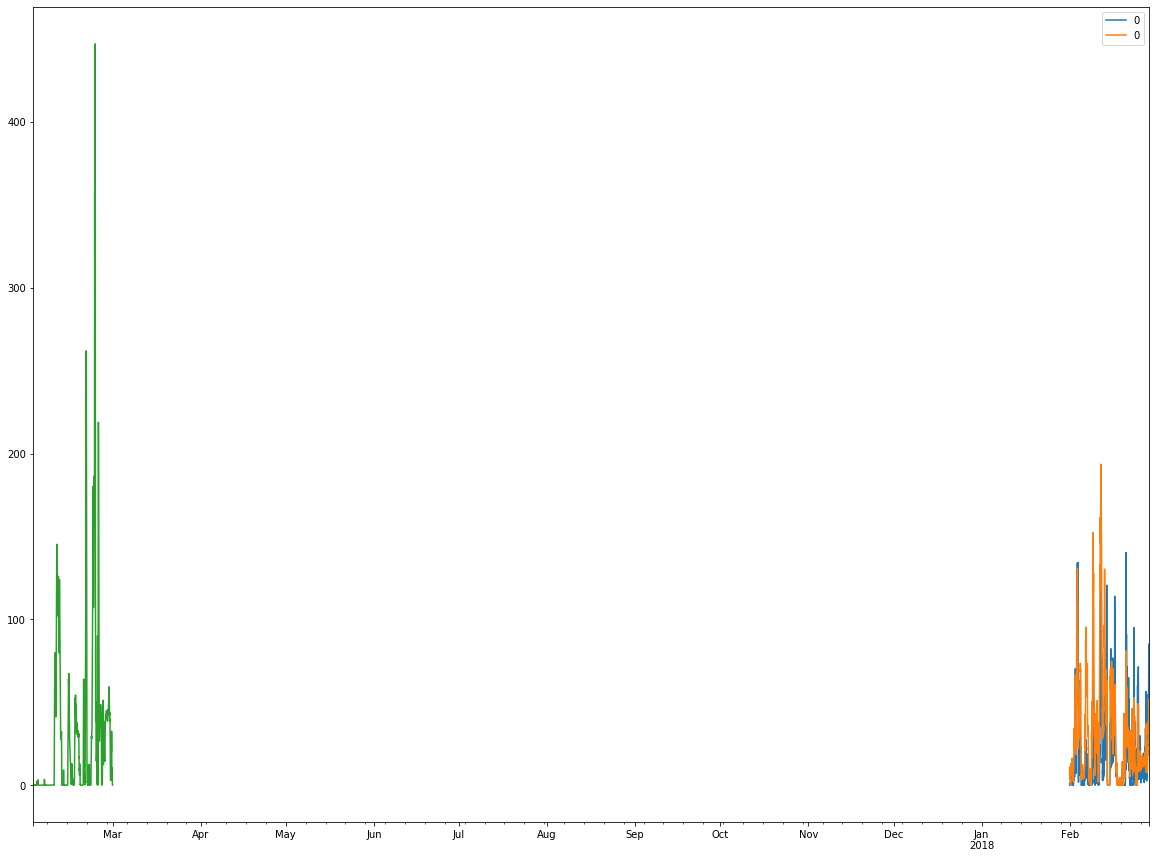

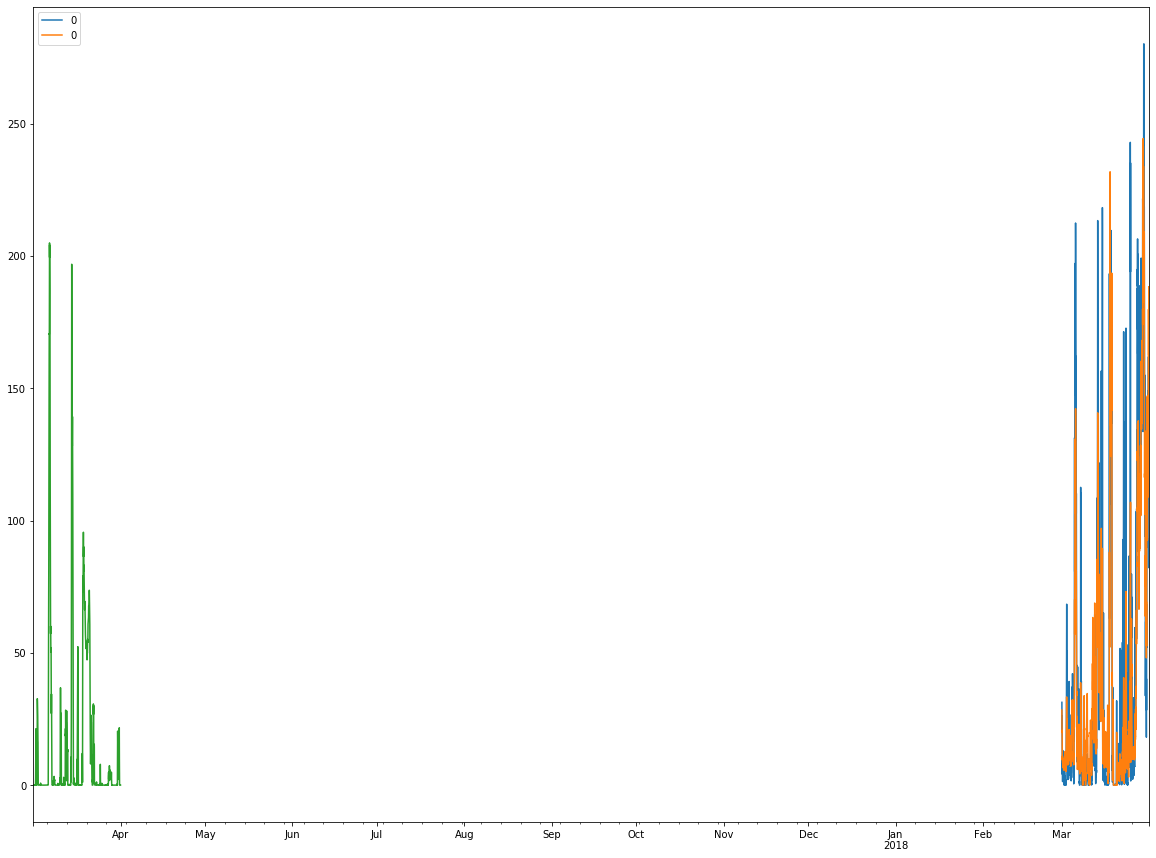

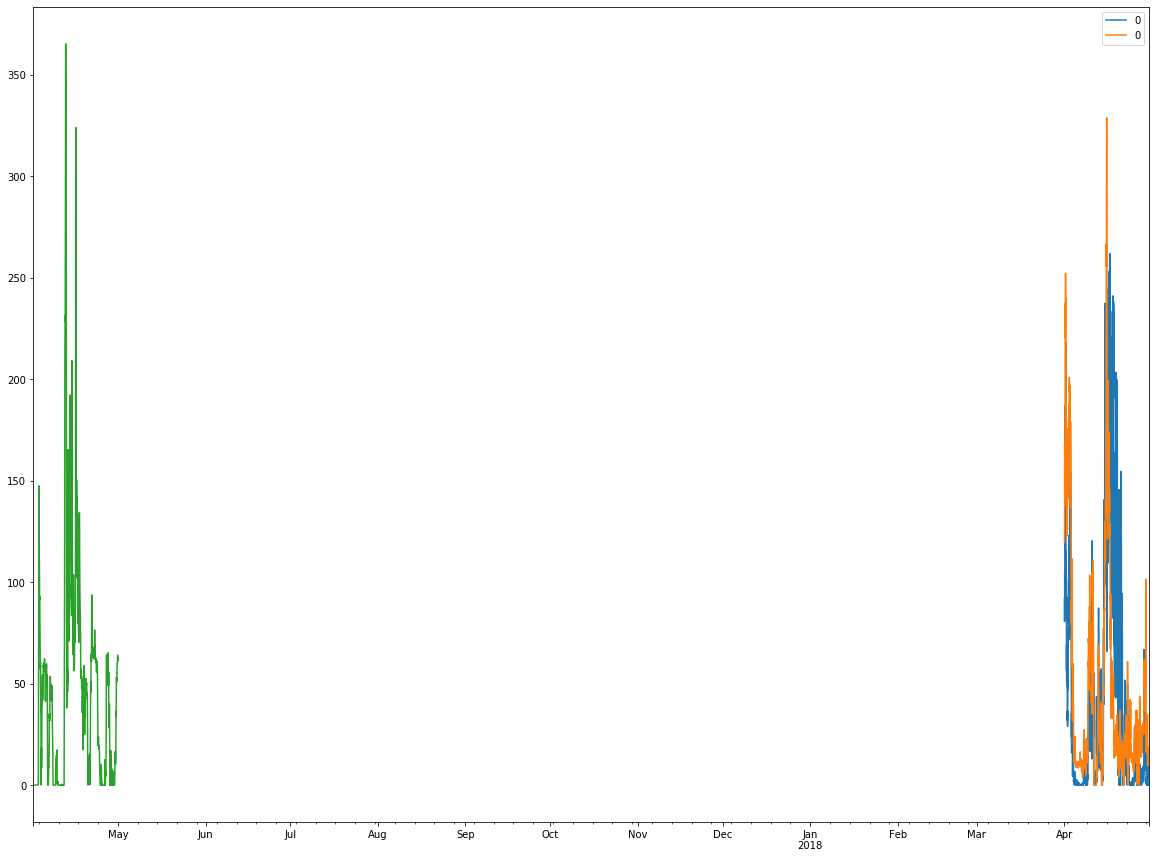

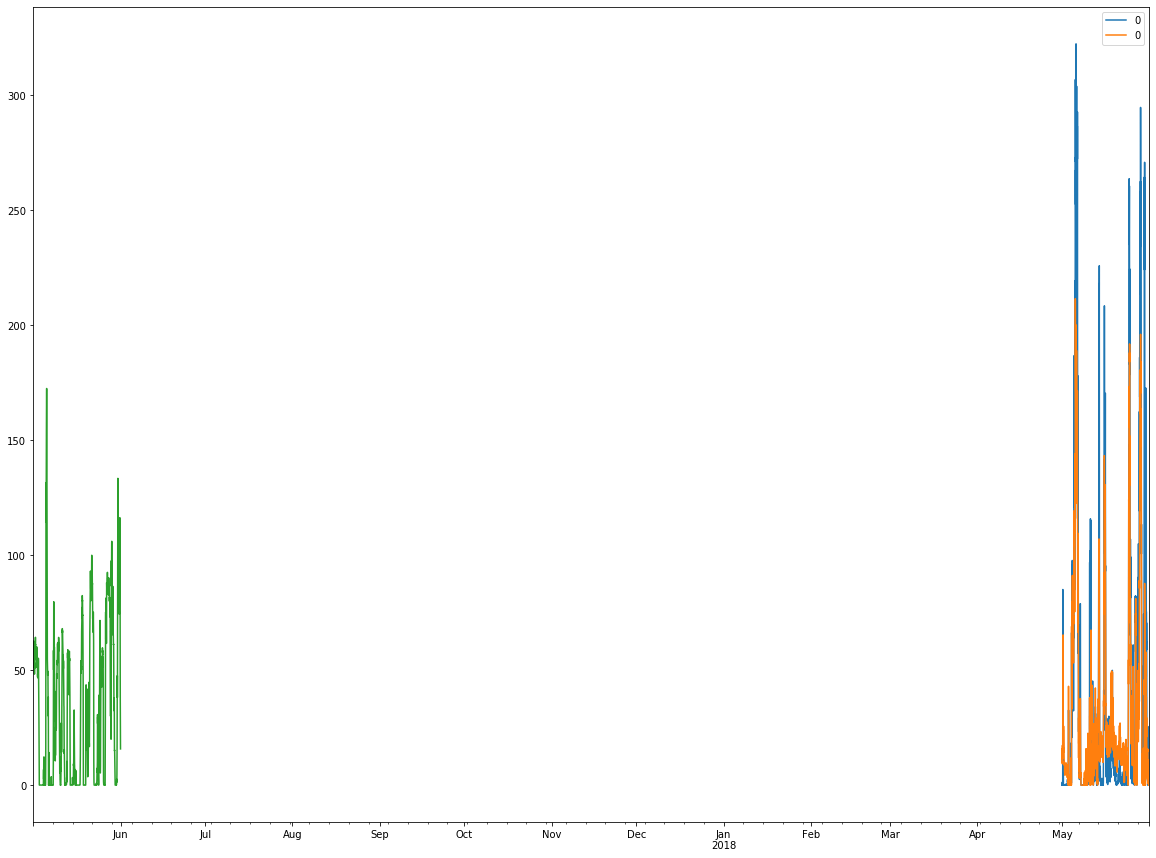

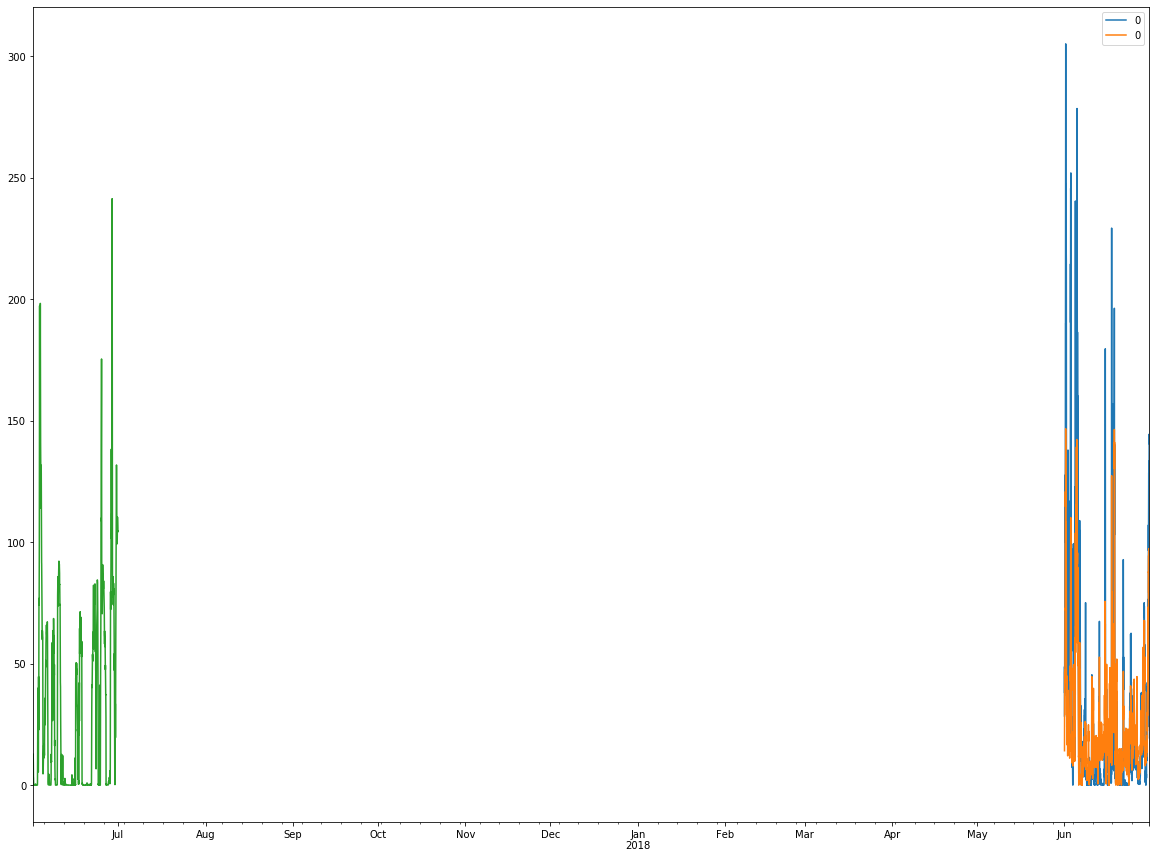

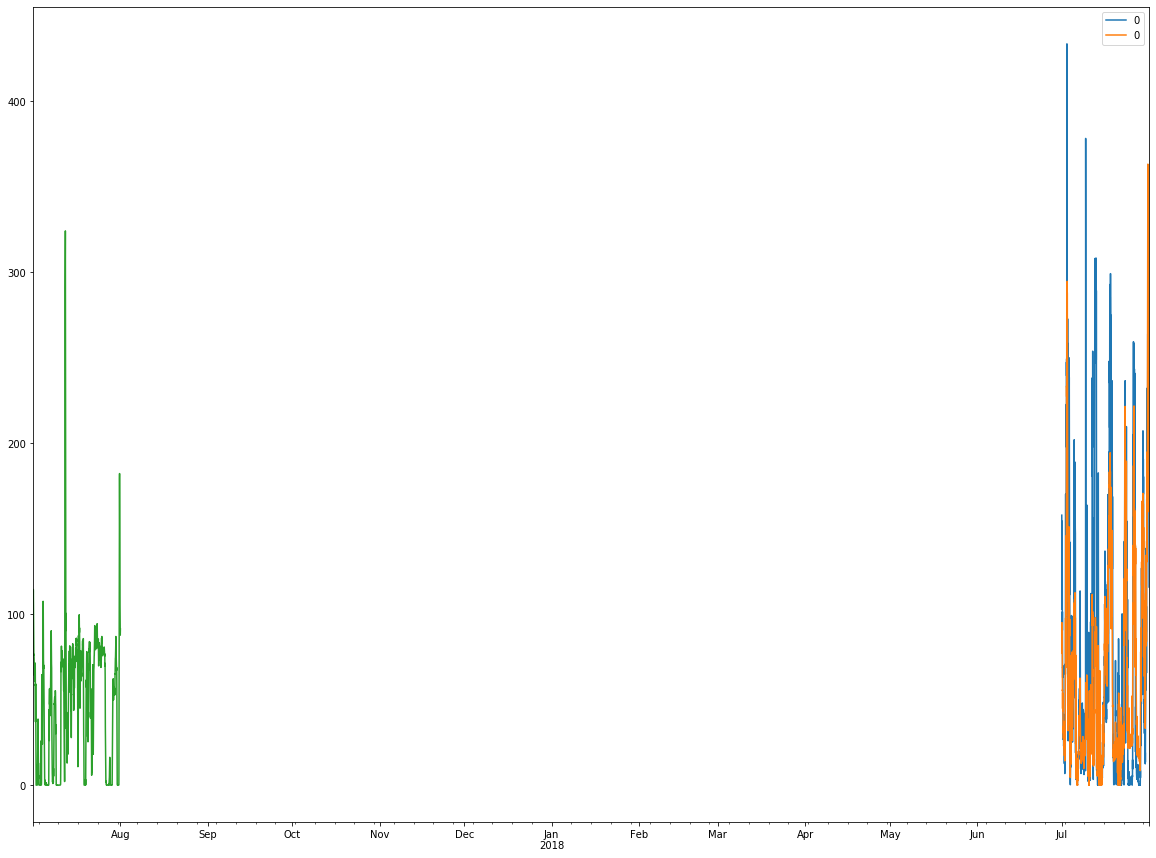

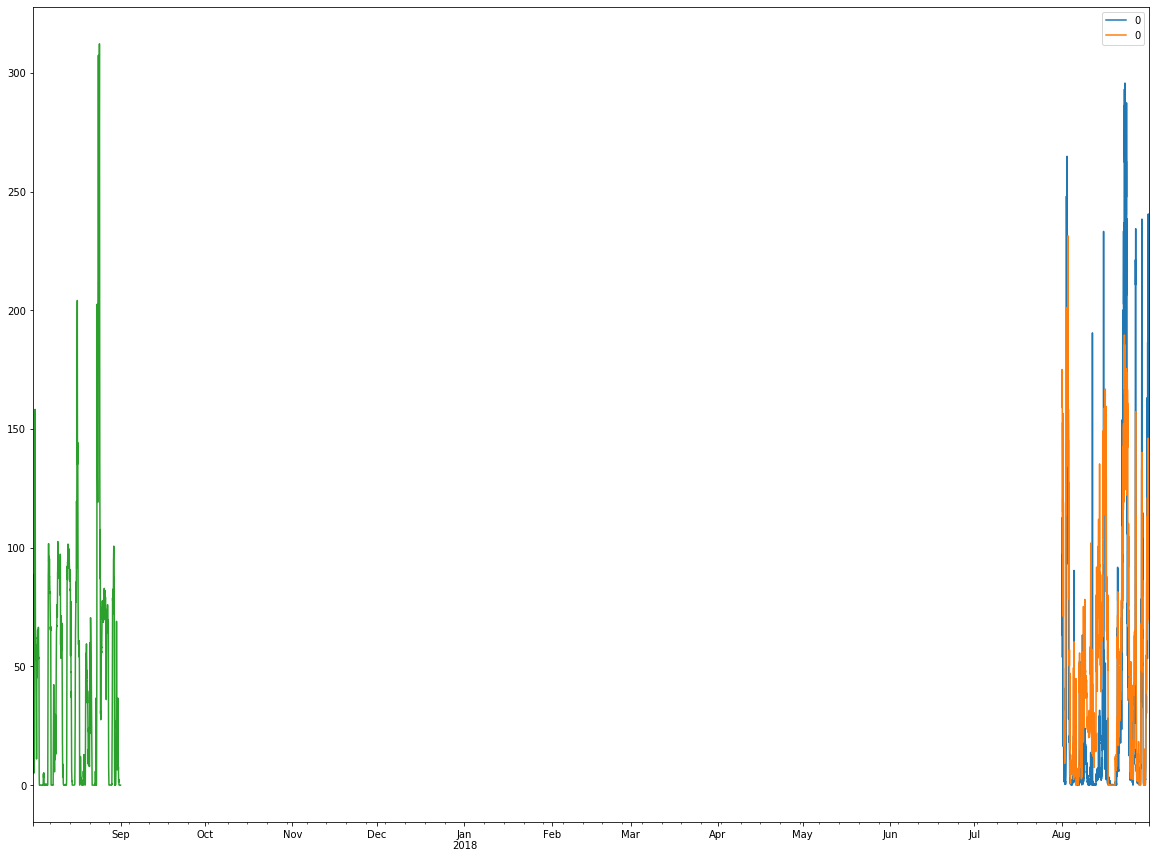

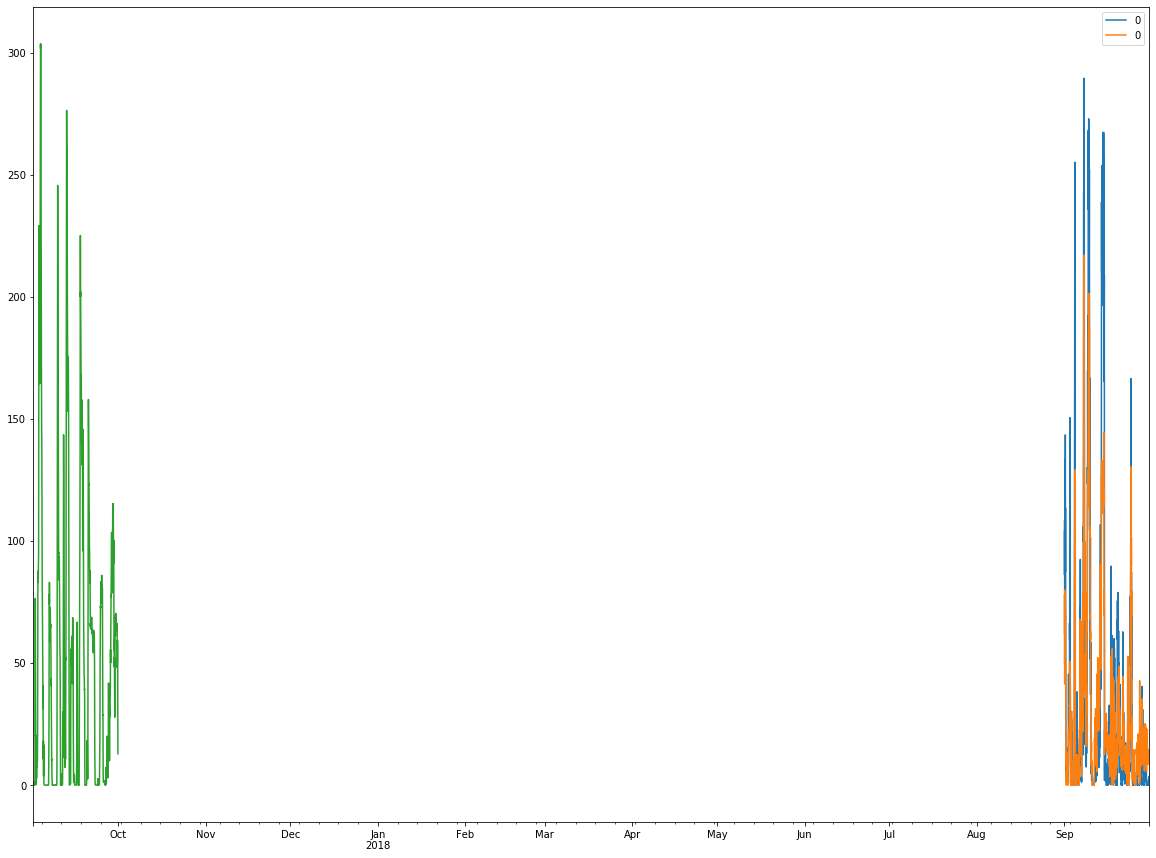

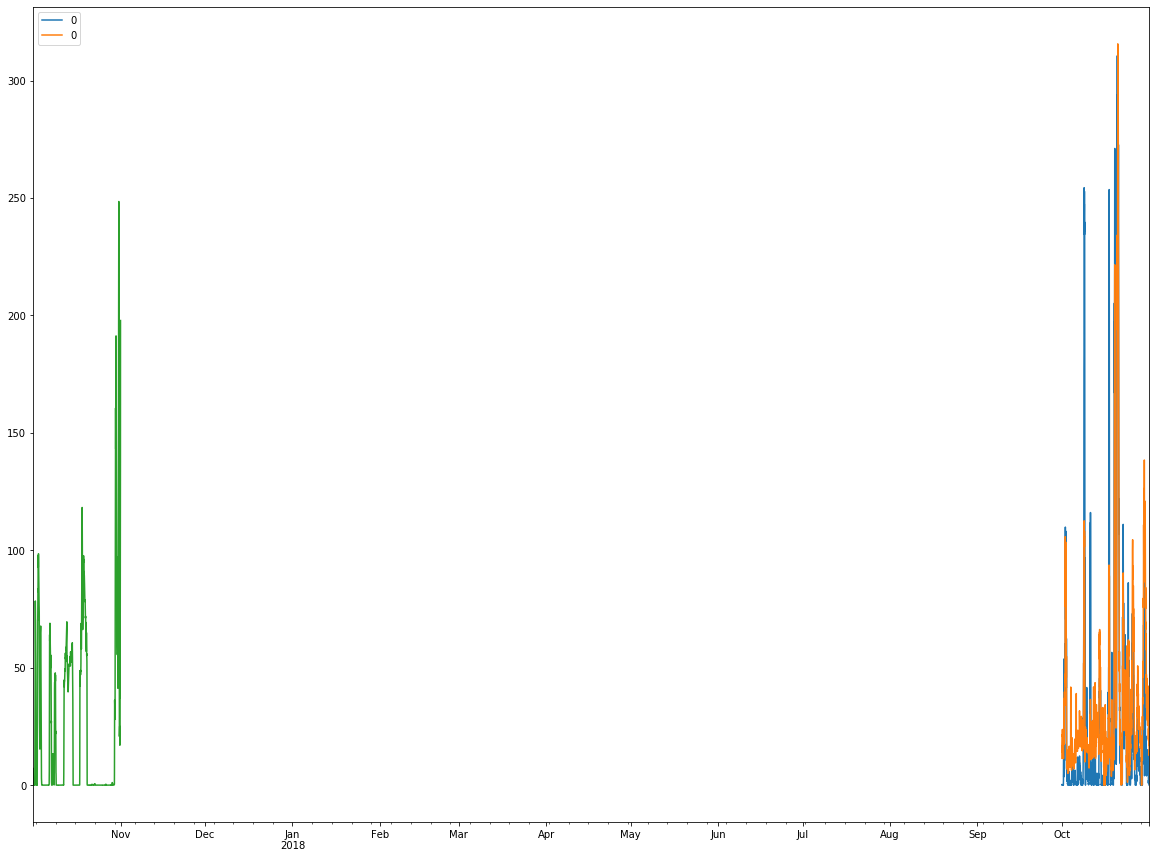

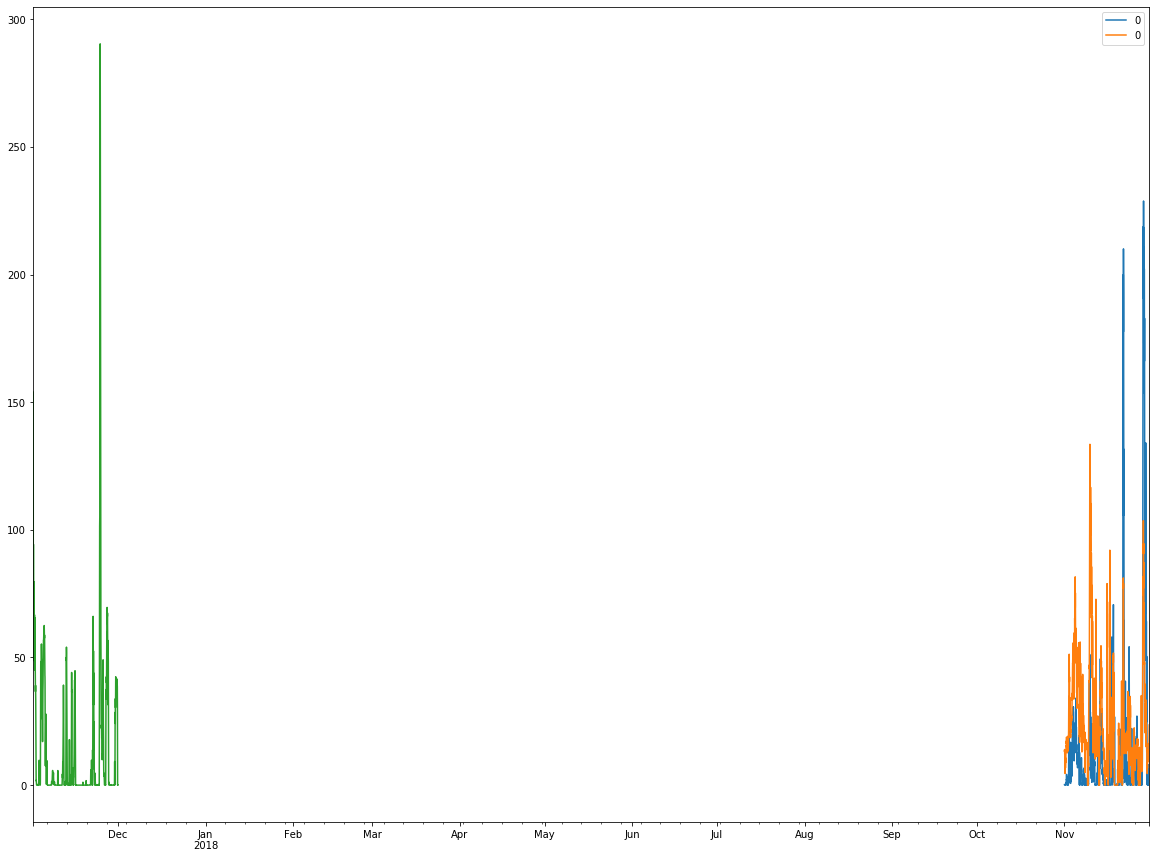

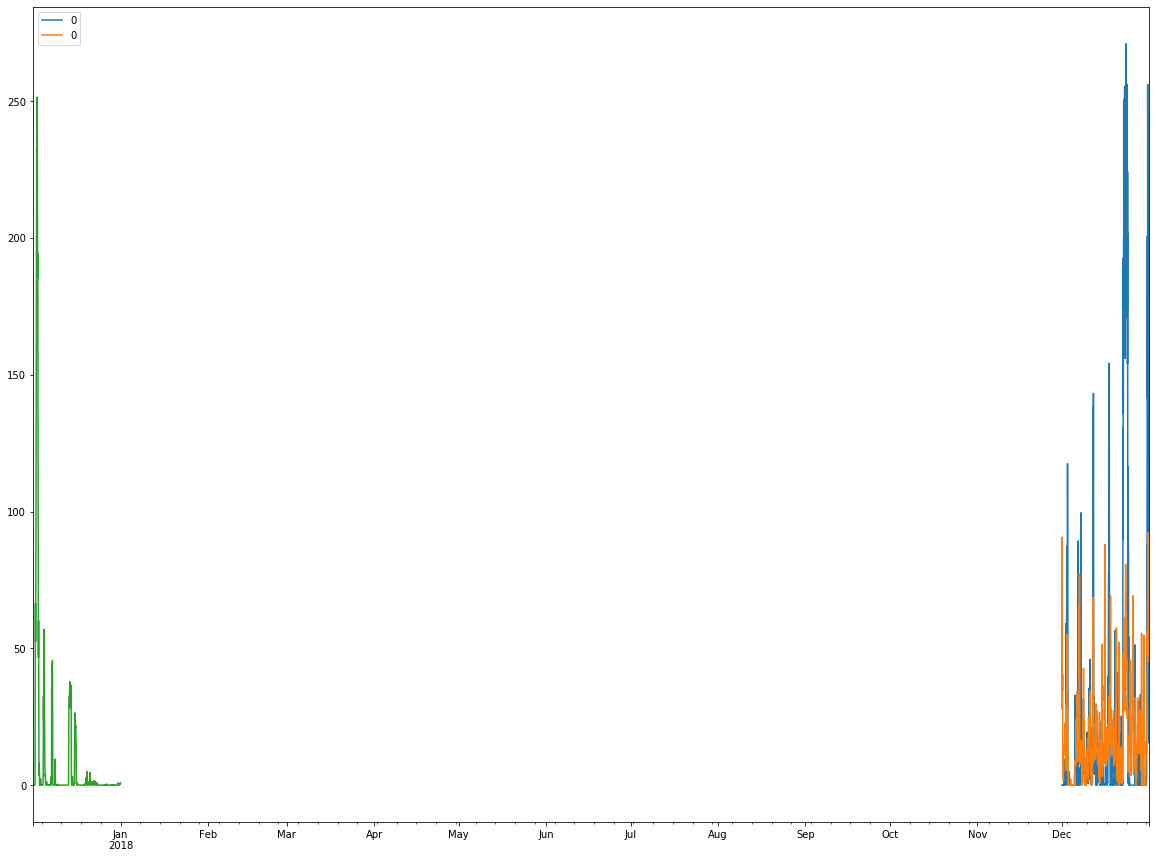

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == 2017) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# SVM

In [0]:
from sklearn.svm import SVR
svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X_train, y_train)

SVR(C=100, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='scale',
    kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = svm_poly_reg.predict(X_test)

In [0]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred)**(0.5)

40.53809868303199

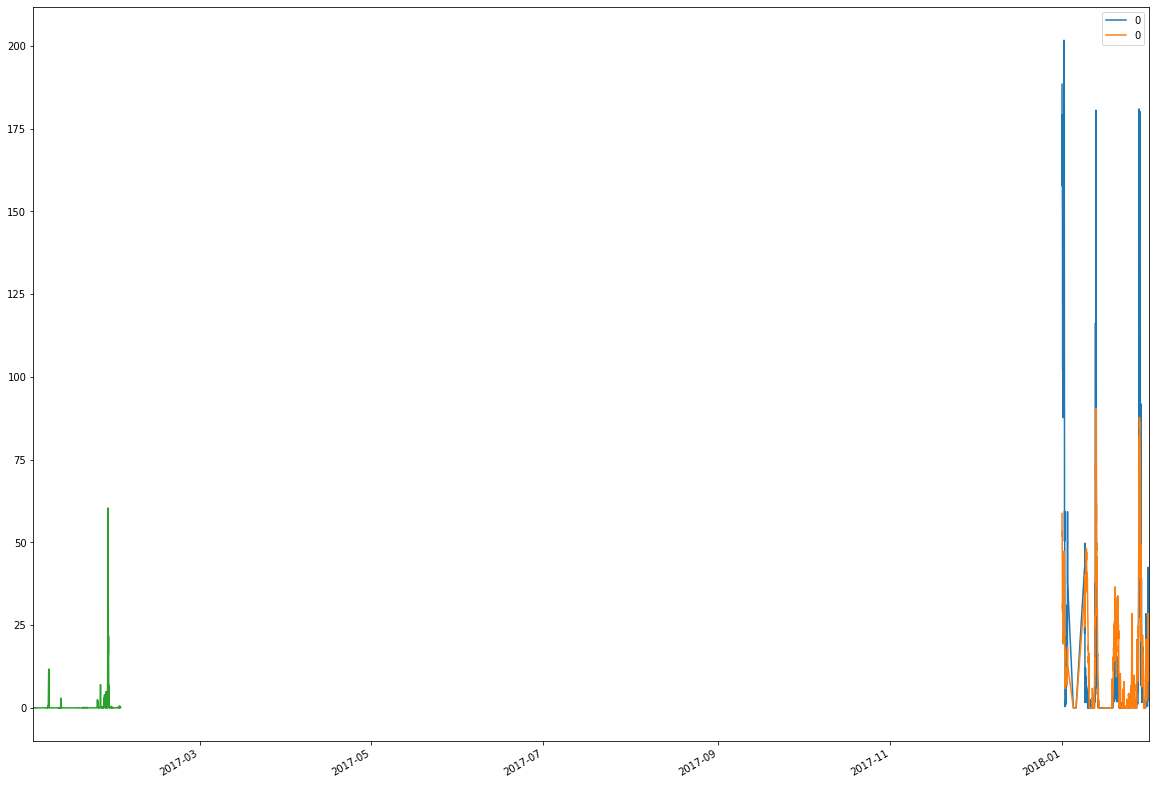

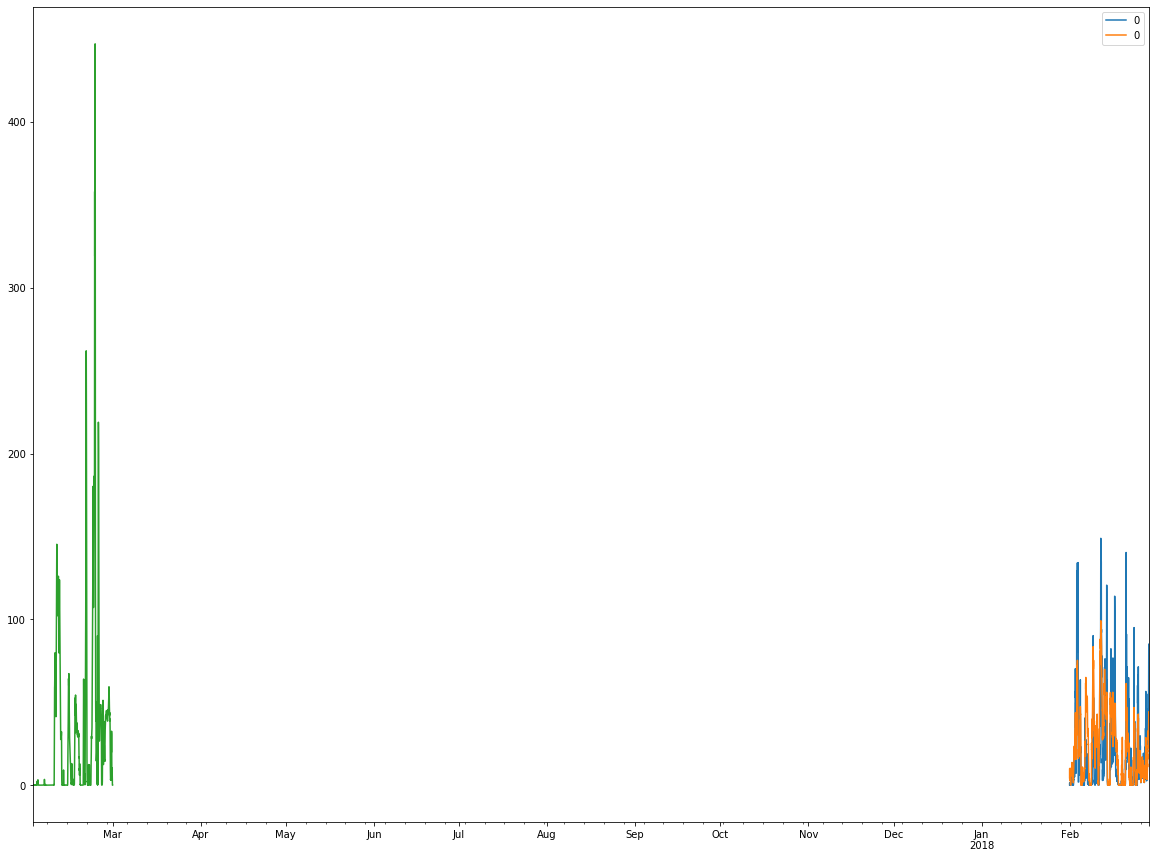

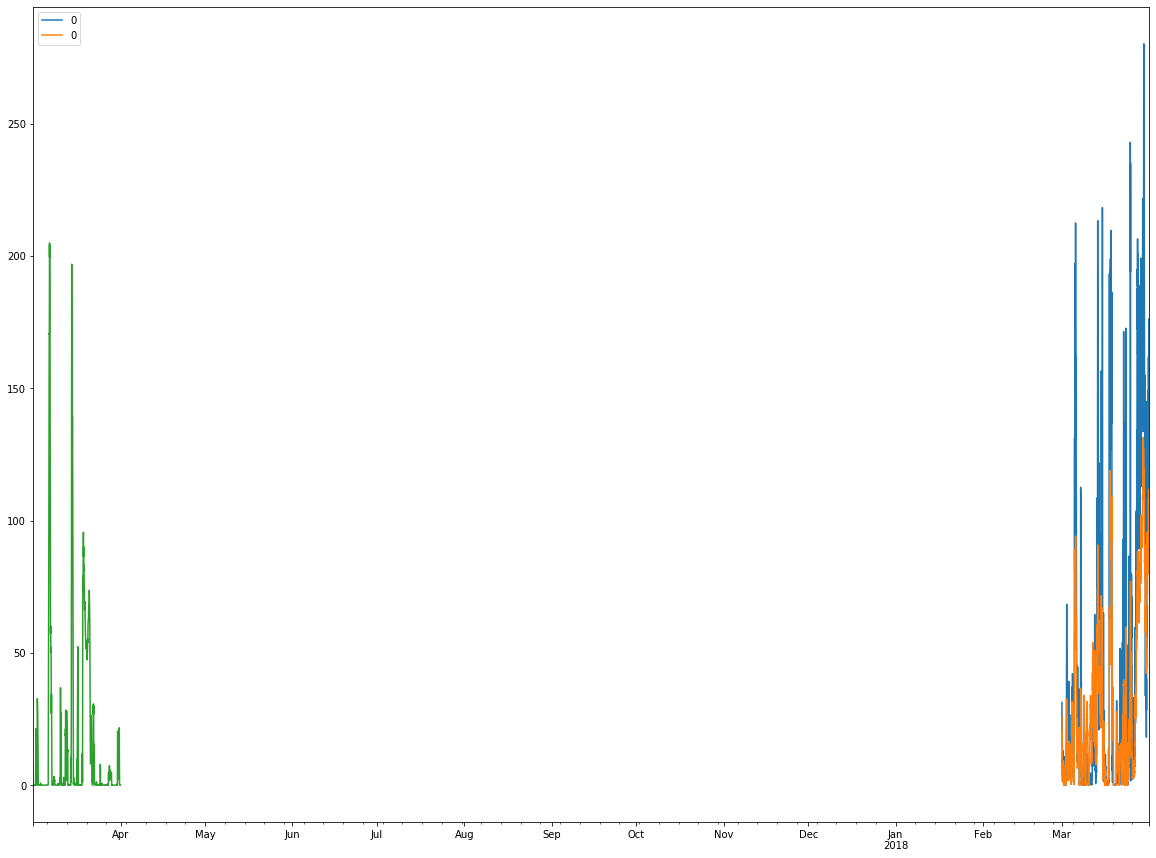

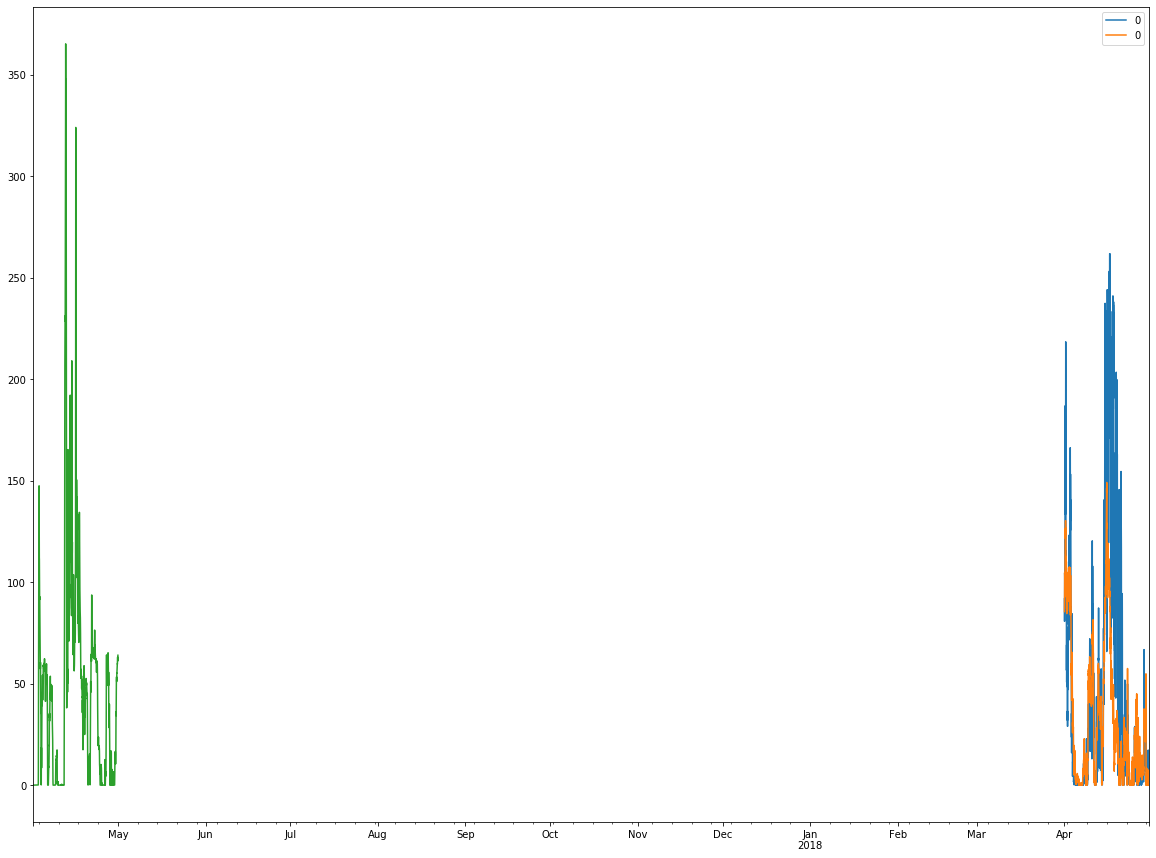

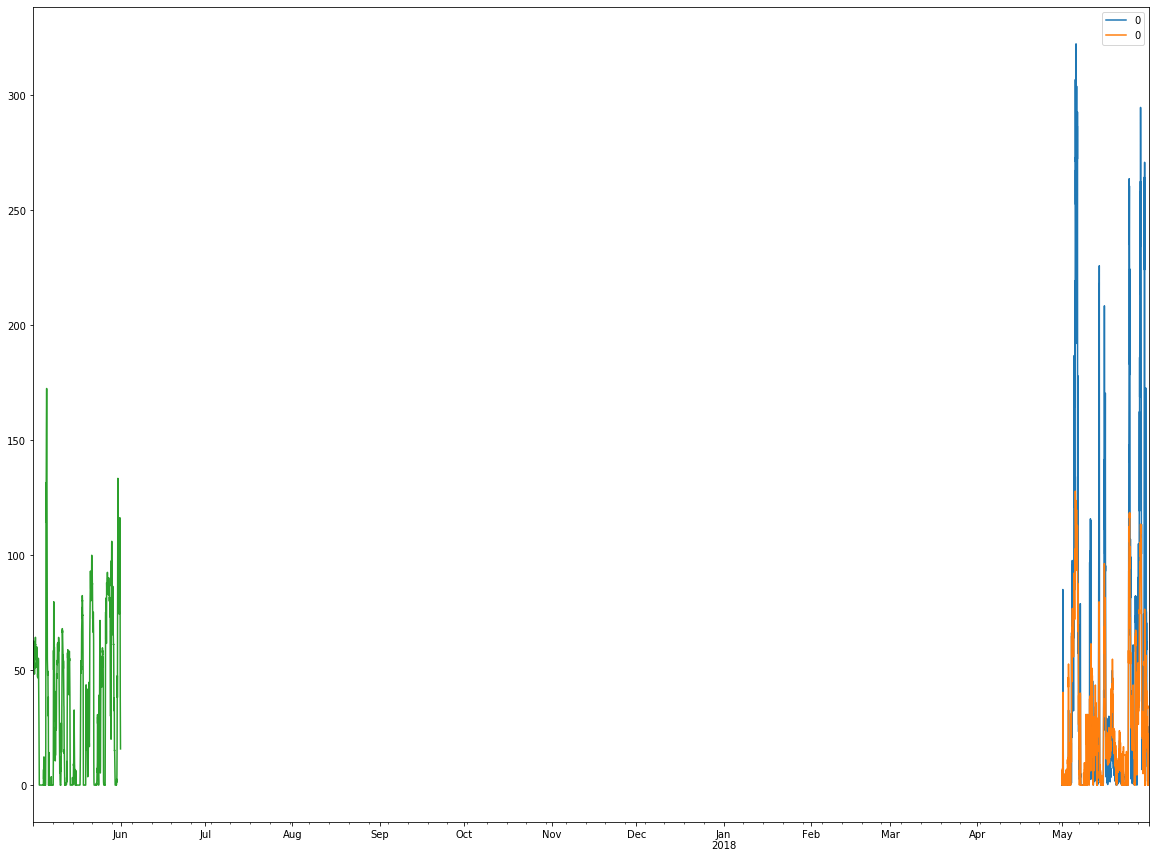

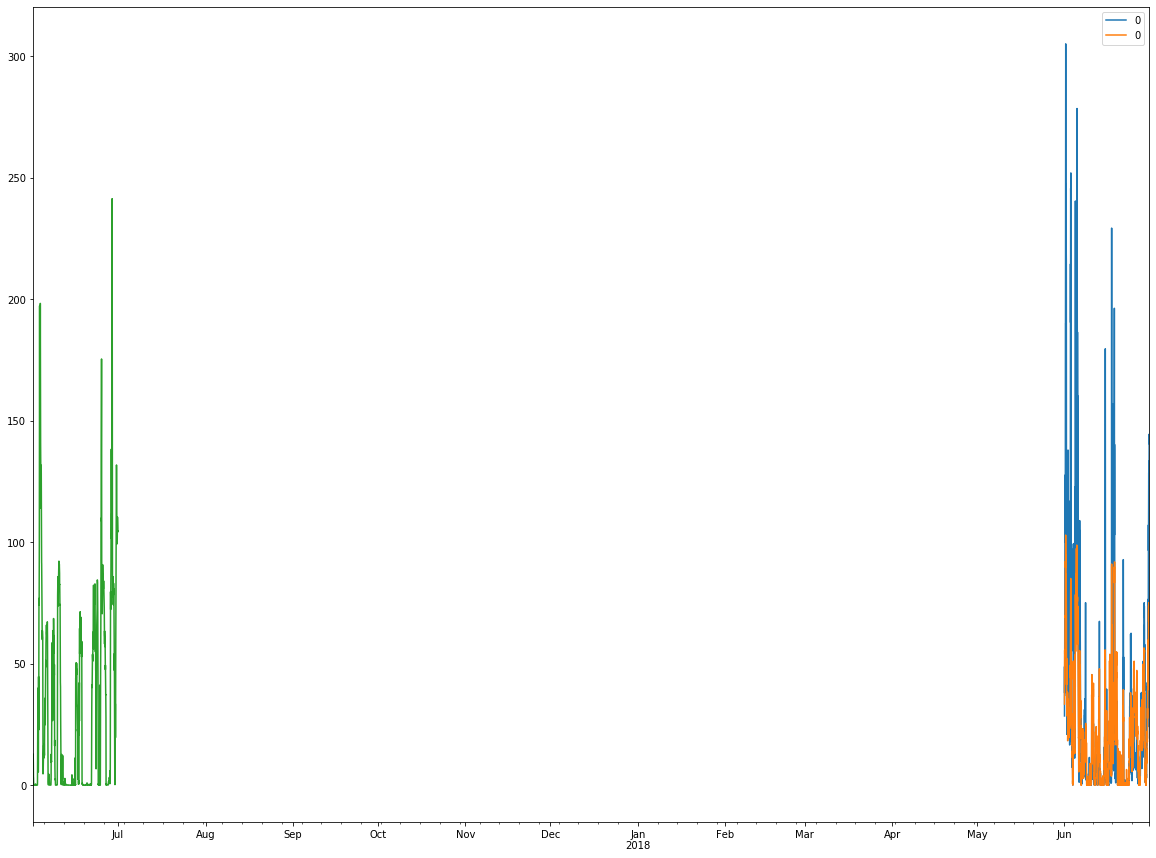

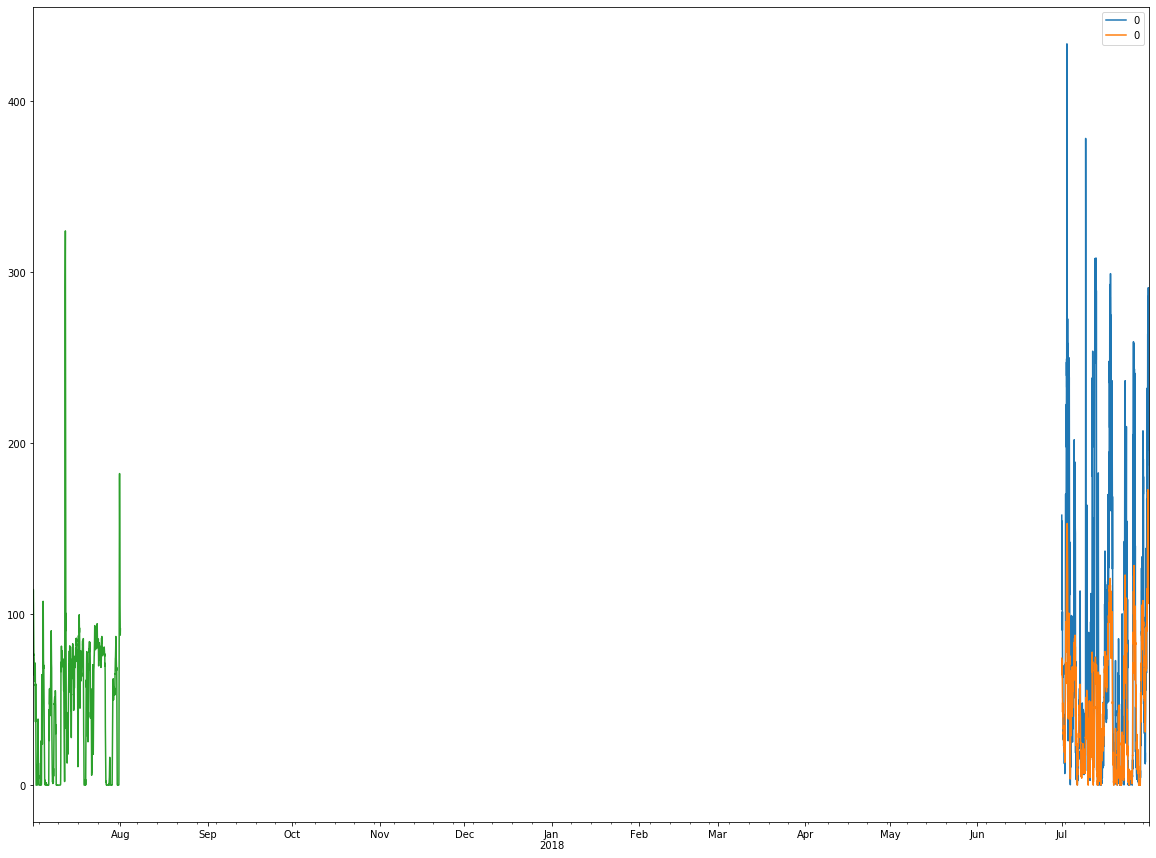

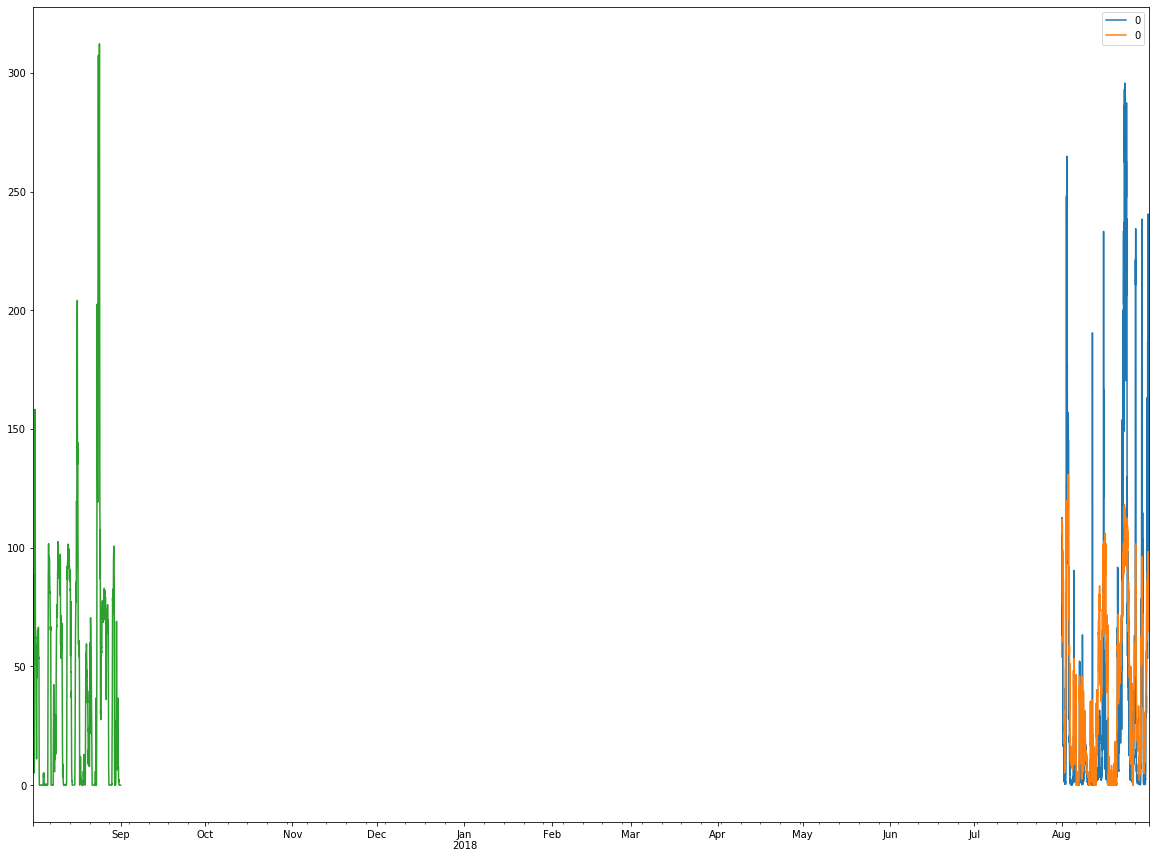

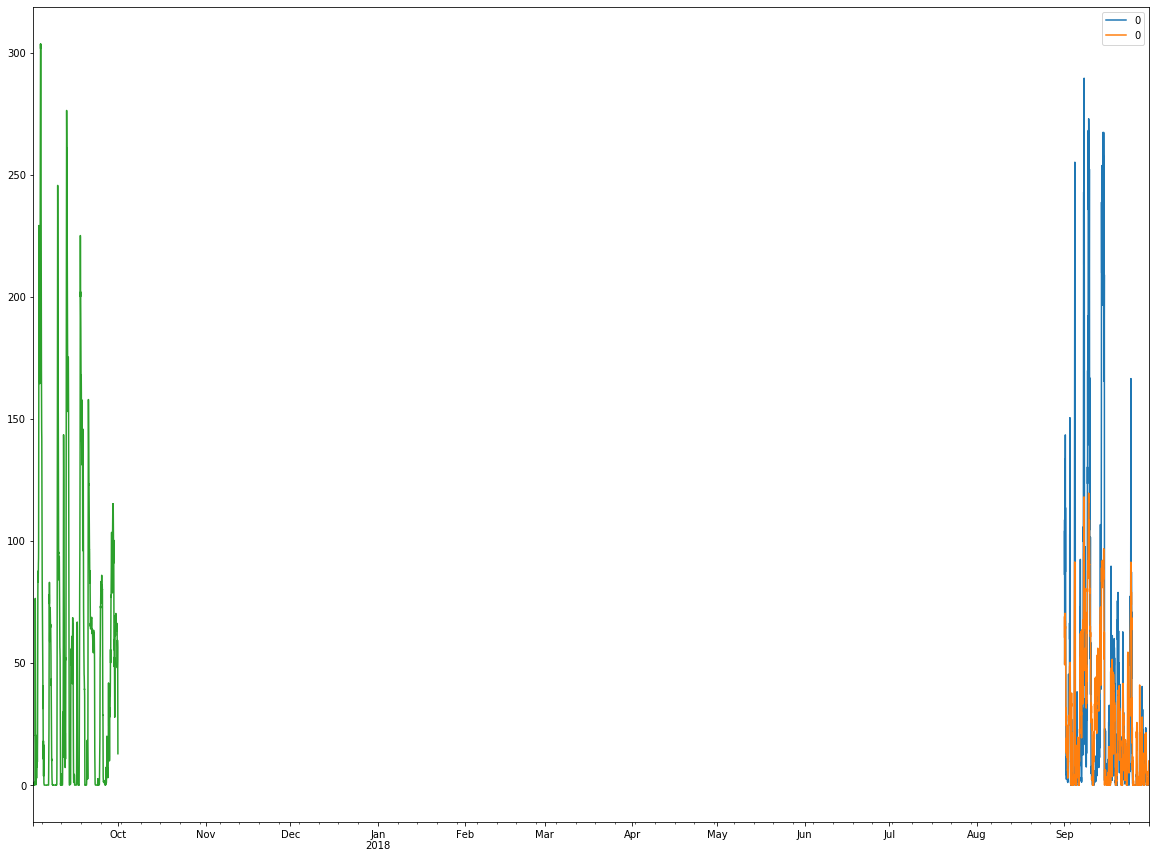

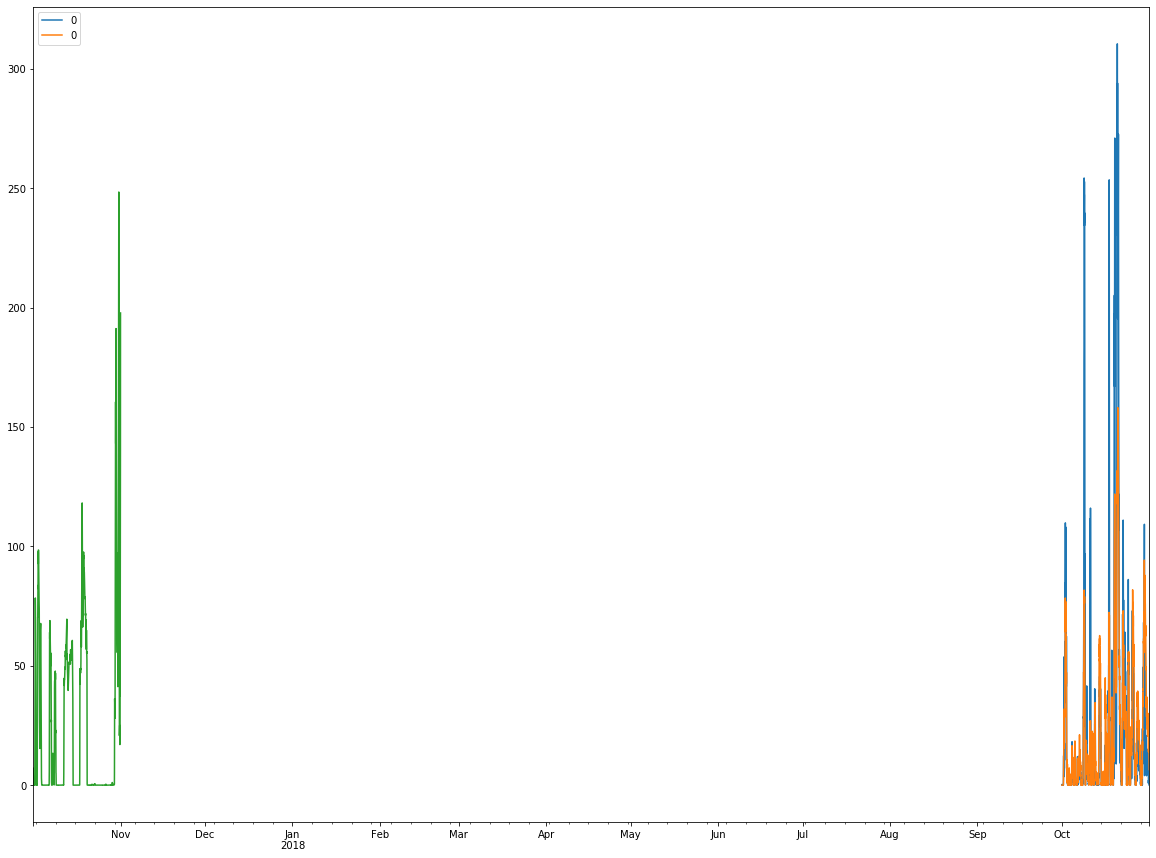

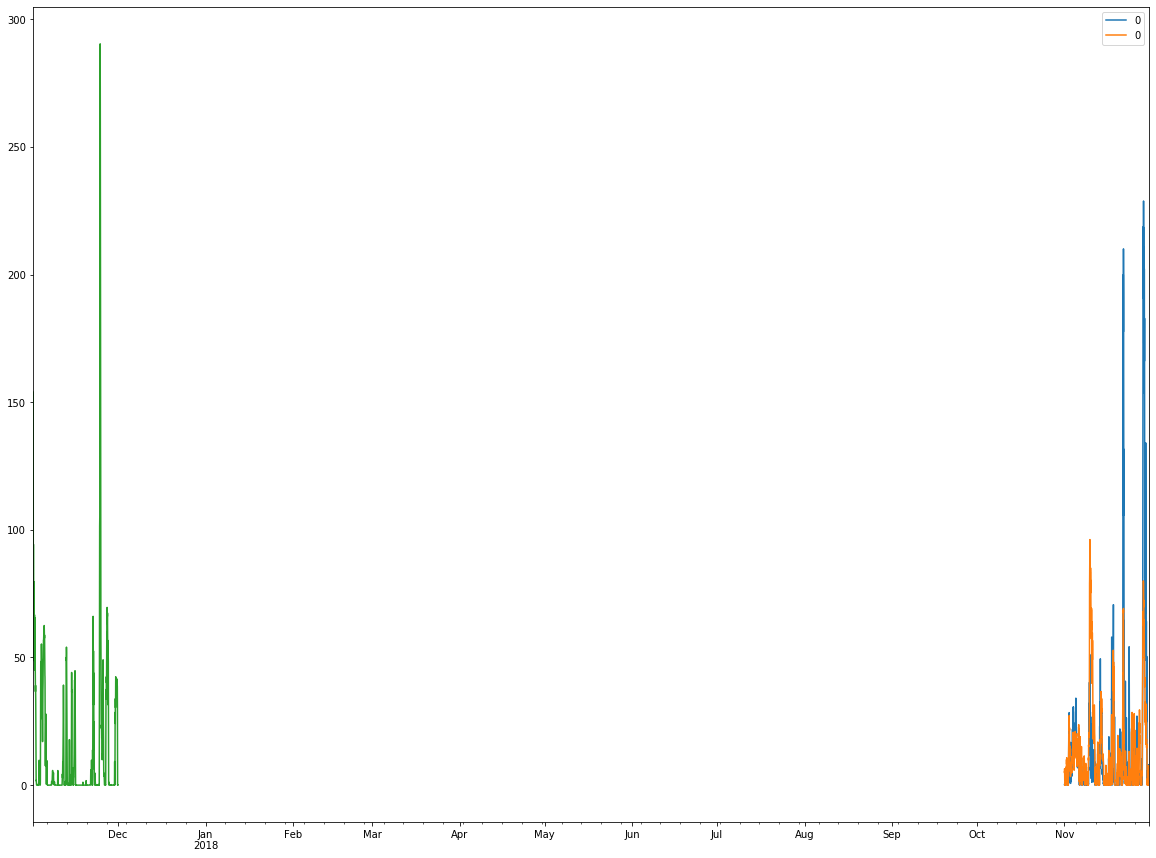

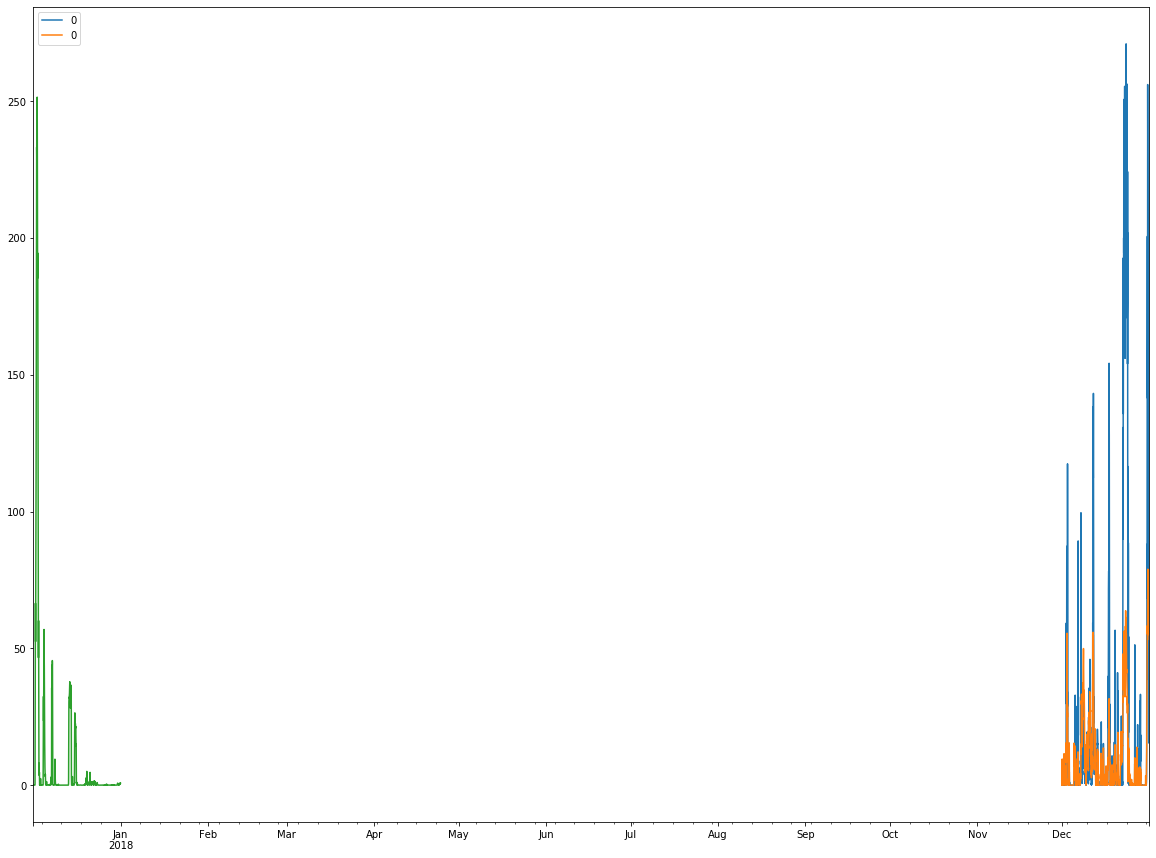

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure()
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax, figsize=(20,15))
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == 2017) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Stacked regression

In [0]:
estimators = [
    ('Random Forest', RandomForestRegressor(n_estimators=500, max_leaf_nodes=150, n_jobs=-1)),
    ('Lasso', Lasso(alpha=0.3))
]

from sklearn.ensemble import StackingRegressor
stacking_regressor = StackingRegressor(
    estimators=estimators, final_estimator=RidgeCV()
)

In [0]:
stacking_regressor.fit(X_train, y_train) 
y_pred = stacking_regressor.predict(X_test)
y_pred = pd.DataFrame(y_pred)
y_test = pd.DataFrame(y_test)
y_pred[y_pred<0] = 0

In [0]:
from sklearn.metrics import mean_squared_error
y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == year_max)].index)]
y_pred = y_pred-y_pred.min()

print('RMSE: \n')
print(mean_squared_error(y_test, y_pred)**(0.5))
print('\nRMSE MAR: \n')
print(mean_squared_error(y_test_MAR, y_test)**(0.5))
print('\n\nBiais corrigé: ')
print(y_pred.mean()-y_test.mean() - y_pred.min())
print('\nBiais MAR: ')
print(y_test_MAR.mean() - y_test.mean())
print('\n\nMoyenne de la prédiction, référence et MAR: ')
print(y_pred.mean())
print(y_test.mean())
print(y_test_MAR.mean())
print("\n\nCorrelation coefficient: ")
print(pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1])
pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1]

RMSE: 

51.586786782330186

RMSE MAR: 

62.42976165678927


Biais corrigé: 
0   -16.84666
dtype: float64

Biais MAR: 
0   -2.867404
dtype: float64


Moyenne de la prédiction, référence et MAR: 
0    17.465772
dtype: float64
0    34.312433
dtype: float64
31.445028889767627


Correlation coefficient: 
nan


0.4031625539212806

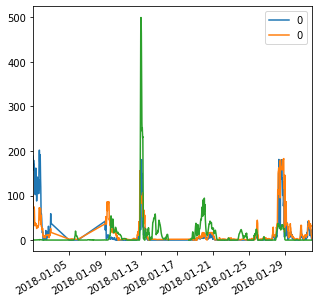

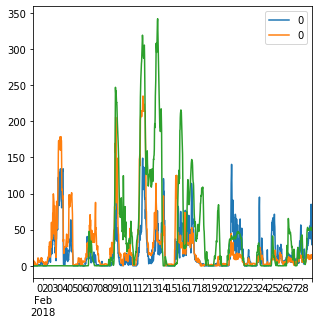

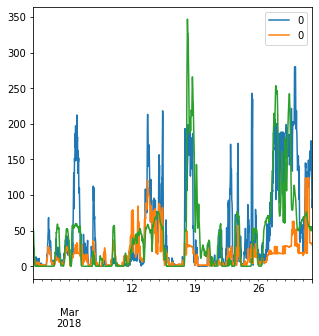

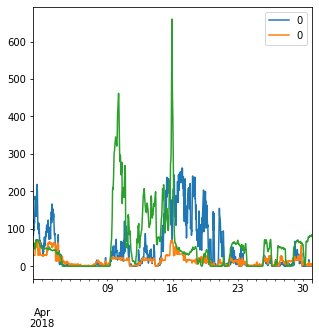

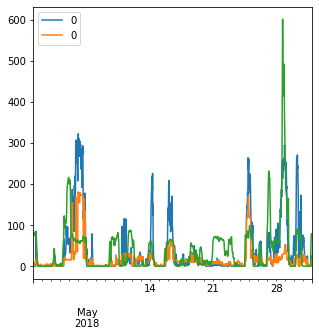

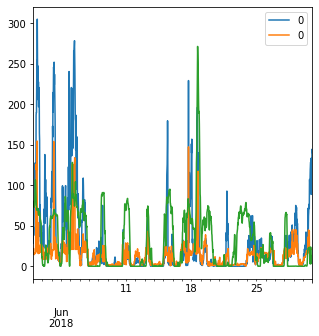

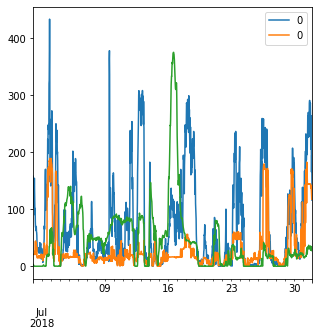

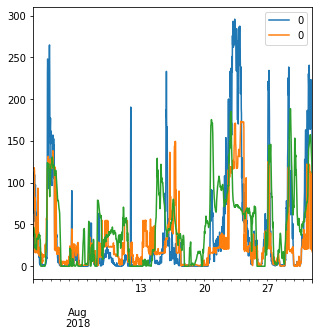

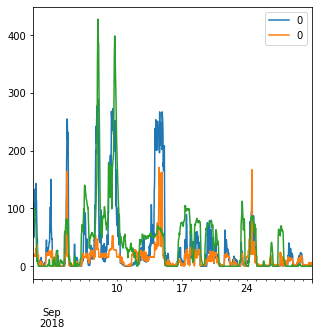

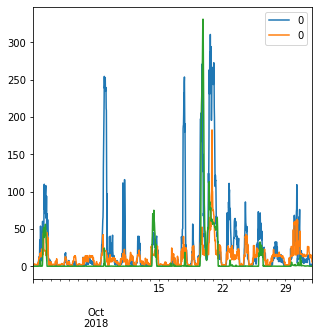

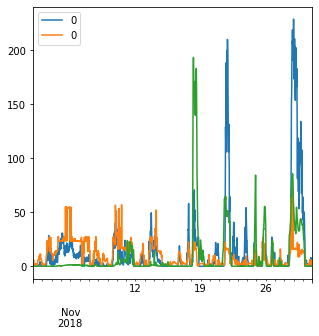

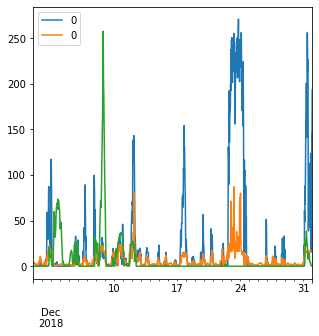

In [0]:
y_pred = pd.DataFrame(y_pred)
y_pred[y_pred<0] = 0
y_pred.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

y_test = pd.DataFrame(y_test)
y_test.index = Dataset['FC_2'][(Dataset.index.year == year_max)].index

for month in range(1,13):
    plt.figure(figsize=(5,5))
    ax = plt.gca()
    y_test[(y_test.index.month == month)].plot(ax=ax)
    y_pred[(y_pred.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    MAR['FC'][(MAR.index.year == year_max) & (MAR.index.month == month)].plot(ax=ax)
    #Dataset['T2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)
    #Dataset['U2m'][(Dataset.index.year == year_max) & (Dataset.index.month == month)].plot(ax=ax)

# Cross validation

In [0]:
def prepare_Dataset(input_variables, input_variables2, test_year, Dataset):

  # Delete NaNs
  Dataset = D17_total[input_variables]
  Dataset = Dataset.dropna()

  # Training and Testing sets
  X_train = Dataset[input_variables2][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  X_test = Dataset[input_variables2][(Dataset.index.year == test_year)].values

  y_train = Dataset['FC_2'][(Dataset.index.year >= 2013) & (Dataset.index.year != test_year)].values
  y_test = Dataset['FC_2'][(Dataset.index.year == test_year)].values
  y_test_index = Dataset['FC_2'][(Dataset.index.year == test_year)].index

  # Validation set
  X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.001)

  # Scale
  scaler = StandardScaler() 
  X_train = scaler.fit_transform(X_train)
  X_valid = scaler.transform(X_valid) 
  X_test = scaler.transform(X_test)

  return(X_train, y_train, X_test, y_test, y_test_index)

In [0]:
def random_forest_regr(X_train, y_train, X_test, y_test):

  # Fit
  rnd_clf = RandomForestRegressor(bootstrap = best_param_rand_forest['bootstrap'],
                                max_depth = best_param_rand_forest['max_depth'],
                                max_features = best_param_rand_forest['max_features'],
                                min_samples_leaf = best_param_rand_forest['min_samples_leaf'],
                                min_samples_split = best_param_rand_forest['min_samples_split'],
                                n_estimators = best_param_rand_forest['n_estimators']-400,
                                n_jobs=-1)
  rnd_clf.fit(X_train, y_train) 

  # Predict
  y_pred = rnd_clf.predict(X_test)
  

  # Cleaning prediction
  y_pred = pd.DataFrame(y_pred)
  y_test = pd.DataFrame(y_test)
  
  y_pred[y_pred<0] = 0
  y_pred = y_pred-y_pred.min()

  corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]
  

  return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [0]:
def poly_regr(X_train, y_train, X_test, y_test):

  # Prepare polynomial features
  poly_features = PolynomialFeatures(degree=2, include_bias=False) 
  X_poly = poly_features.fit_transform(X_train)

  # Fit
  lasso_reg = Lasso(alpha=0.3)
  lasso_reg.fit(X_poly, y_train)

  # Predict
  X_test_poly = poly_features.fit_transform(X_test)
  y_pred = lasso_reg.predict(X_test_poly)

  # Cleaning prediction
  y_pred = pd.DataFrame(y_pred)
  y_test = pd.DataFrame(y_test)
  y_pred[y_pred<0] = 0
  y_pred = y_pred-y_pred.min()

  corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]
  

  return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))


In [0]:
def lasso_regr(X_train, y_train, X_test, y_test):

  # Fit
  lasso_reg = Lasso(alpha=0.3)
  lasso_reg.fit(X_train, y_train)

  # Predict
  y_pred = lasso_reg.predict(X_test)

  # Cleaning prediction
  y_pred = pd.DataFrame(y_pred)
  y_test = pd.DataFrame(y_test)
  y_pred[y_pred<0] = 0
  y_pred = y_pred-y_pred.min()

  corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]
  

  return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [0]:
def dnn_regr(X_train, y_train, X_test, y_test):

  # Fit
  best_dnn.fit(X_train, y_train, best_model_parameters_export['epochs'], verbose=0) 

  # Predict
  y_pred = best_dnn.predict(X_test)
  

  # Cleaning prediction
  y_pred = pd.DataFrame(y_pred)
  y_test = pd.DataFrame(y_test)
  y_pred[y_pred<0] = 0

  corr_coeff = pd.concat([y_pred, y_test], axis=1).corr().iloc[0,1]
  

  return((mean_squared_error(y_test, y_pred)**(0.5), corr_coeff, y_pred))

In [0]:
def cross_validate(inputs_variables, input_variable_2, Dataset):

  list_years = [2013,2015,2016,2017,2018]

  # Initialization mse list
  list_lasso = []
  list_poly = []
  list_random_forest = []
  list_dnn = []
  list_MAR = []

  # Initialization corr coeff list
  list_lasso_corr = []
  list_poly_corr = []
  list_random_forest_corr = []
  list_dnn_corr = []
  list_MAR_corr = []

  # Initialization y_pred list
  list_lasso_y_pred = []
  list_poly_y_pred = []
  list_random_forest_y_pred = []
  list_dnn_y_pred = []
  list_MAR_y_pred = []
  list_index = []





  for test_year in list_years:
    start_time1 = time.time()
    start_time = time.time()
    X_train, y_train, X_test, y_test, y_test_index = prepare_Dataset(inputs_variables, input_variable_2, test_year, Dataset)
    list_index.append(y_test_index)
    print('\n'+str(test_year))

    # Fit training data and predicting testing data
    '''
    ______________________________________________
    ___________________Lasso______________________
    ______________________________________________
    '''
    result_lasso = lasso_regr(X_train, y_train, X_test, y_test)
    list_lasso.append(result_lasso[0])
    list_lasso_corr.append(result_lasso[1])
    list_lasso_y_pred.append(result_lasso[2])
    print('Lasso finished')
    print("--- %s seconds for Lasso" % (time.time() - start_time))

    '''
    ______________________________________________
    ___________________Polyn______________________
    ______________________________________________
    '''

    result_poly = poly_regr(X_train, y_train, X_test, y_test)
    list_poly.append(result_poly[0])
    list_poly_corr.append(result_poly[1])
    list_poly_y_pred.append(result_poly[2])
    print('Poly finished')
    print("--- %s seconds for Poly" % (time.time() - start_time))

    '''
    ______________________________________________
    ___________________Random Forest______________
    ______________________________________________
    '''

    result_forest = random_forest_regr(X_train, y_train, X_test, y_test)
    list_random_forest.append(result_forest[0])
    list_random_forest_corr.append(result_forest[1])
    list_random_forest_y_pred.append(result_forest[2])
    print('Random forest finished')
    print("--- %s seconds for Forest" % (time.time() - start_time))

    '''
    ______________________________________________
    ____________________DNN_______________________
    ______________________________________________
    '''
    result_dnn = dnn_regr(X_train, y_train, X_test, y_test)
    list_dnn.append(result_dnn[0])
    list_dnn_corr.append(result_dnn[1])
    list_dnn_y_pred.append(result_dnn[2])
    print('Deep neural network finished')
    print("--- %s seconds for DNN" % (time.time() - start_time))
    
    '''
    ______________________________________________
    ____________________MAR_______________________
    ______________________________________________
    '''

    y_test = pd.DataFrame(y_test)
    y_test_MAR = MAR['FC'][MAR.index.isin(Dataset['FC_2'][(Dataset.index.year == test_year)].index)]
    y_test_MAR = y_test_MAR.to_frame()
    y_test.index = y_test_MAR.index
    # RMSE
    list_MAR.append(mean_squared_error(y_test, y_test_MAR)**(0.5))
    # Correlation coefficient
    list_MAR_corr.append(pd.concat([y_test_MAR, y_test], axis=1).corr().iloc[0,1])
    # y_pred
    list_MAR_y_pred.append(y_test_MAR)
    print(str(test_year))
    print("--- %s seconds for ---" % (time.time() - start_time1))




  # Creating DataFrame
  df_rmse = pd.DataFrame(index = [2013,2015,2016,2017,2018])
  df_rmse['lasso_rmse'] = list_lasso
  df_rmse['poly_rmse'] = list_poly
  df_rmse['random_forest_rmse'] = list_random_forest
  df_rmse['MAR_rmse'] = list_MAR
  df_rmse['dnn'] = list_dnn

  df_rmse['lasso_corr'] = list_lasso_corr
  df_rmse['poly_corr'] = list_poly_corr
  df_rmse['random_forest_corr'] = list_random_forest_corr
  df_rmse['MAR_corr'] = list_MAR_corr
  df_rmse['dnn_corr'] = list_dnn_corr

  list_y_pred =   [list_lasso_y_pred, list_poly_y_pred, list_random_forest_y_pred, list_dnn_y_pred, list_MAR_y_pred]

  return(df_rmse, list_y_pred, list_index)

In [0]:
df_rmse1, list_y_pred, list_index = cross_validate(variables, variables[:-1], Dataset)


2013
Lasso finished
--- 0.21553564071655273 seconds for Lasso
Poly finished
--- 0.3403148651123047 seconds for Poly
Random forest finished
--- 39.258790493011475 seconds for Forest
Deep neural network finished
--- 60.754706621170044 seconds for DNN
2013
--- 60.771350145339966 seconds for ---

2015
Lasso finished
--- 0.13789606094360352 seconds for Lasso
Poly finished
--- 0.3383798599243164 seconds for Poly
Random forest finished
--- 39.32483911514282 seconds for Forest
Deep neural network finished
--- 61.22979927062988 seconds for DNN
2015
--- 61.245859146118164 seconds for ---

2016
Lasso finished
--- 0.12716269493103027 seconds for Lasso
Poly finished
--- 0.627077579498291 seconds for Poly
Random forest finished
--- 39.98888540267944 seconds for Forest
Deep neural network finished
--- 61.46655583381653 seconds for DNN
2016
--- 61.48252606391907 seconds for ---

2017
Lasso finished
--- 0.1257190704345703 seconds for Lasso
Poly finished
--- 0.43932318687438965 seconds for Poly
Random 

In [0]:
print('STD: \n')
print(df_rmse1.std())
print('\n Mean: \n')
df_rmse1.mean()

STD: 

lasso_rmse             6.457219
poly_rmse              4.520575
random_forest_rmse     5.849715
MAR_rmse               4.833875
dnn                   10.627787
lasso_corr             0.019948
poly_corr              0.047837
random_forest_corr     0.097822
MAR_corr               0.082958
dnn_corr               0.183155
dtype: float64

 Mean: 



lasso_rmse            40.333450
poly_rmse             38.810140
random_forest_rmse    41.129723
MAR_rmse              59.465849
dnn                   39.892703
lasso_corr             0.797833
poly_corr              0.826750
random_forest_corr     0.791041
MAR_corr               0.480267
dnn_corr               0.785431
dtype: float64

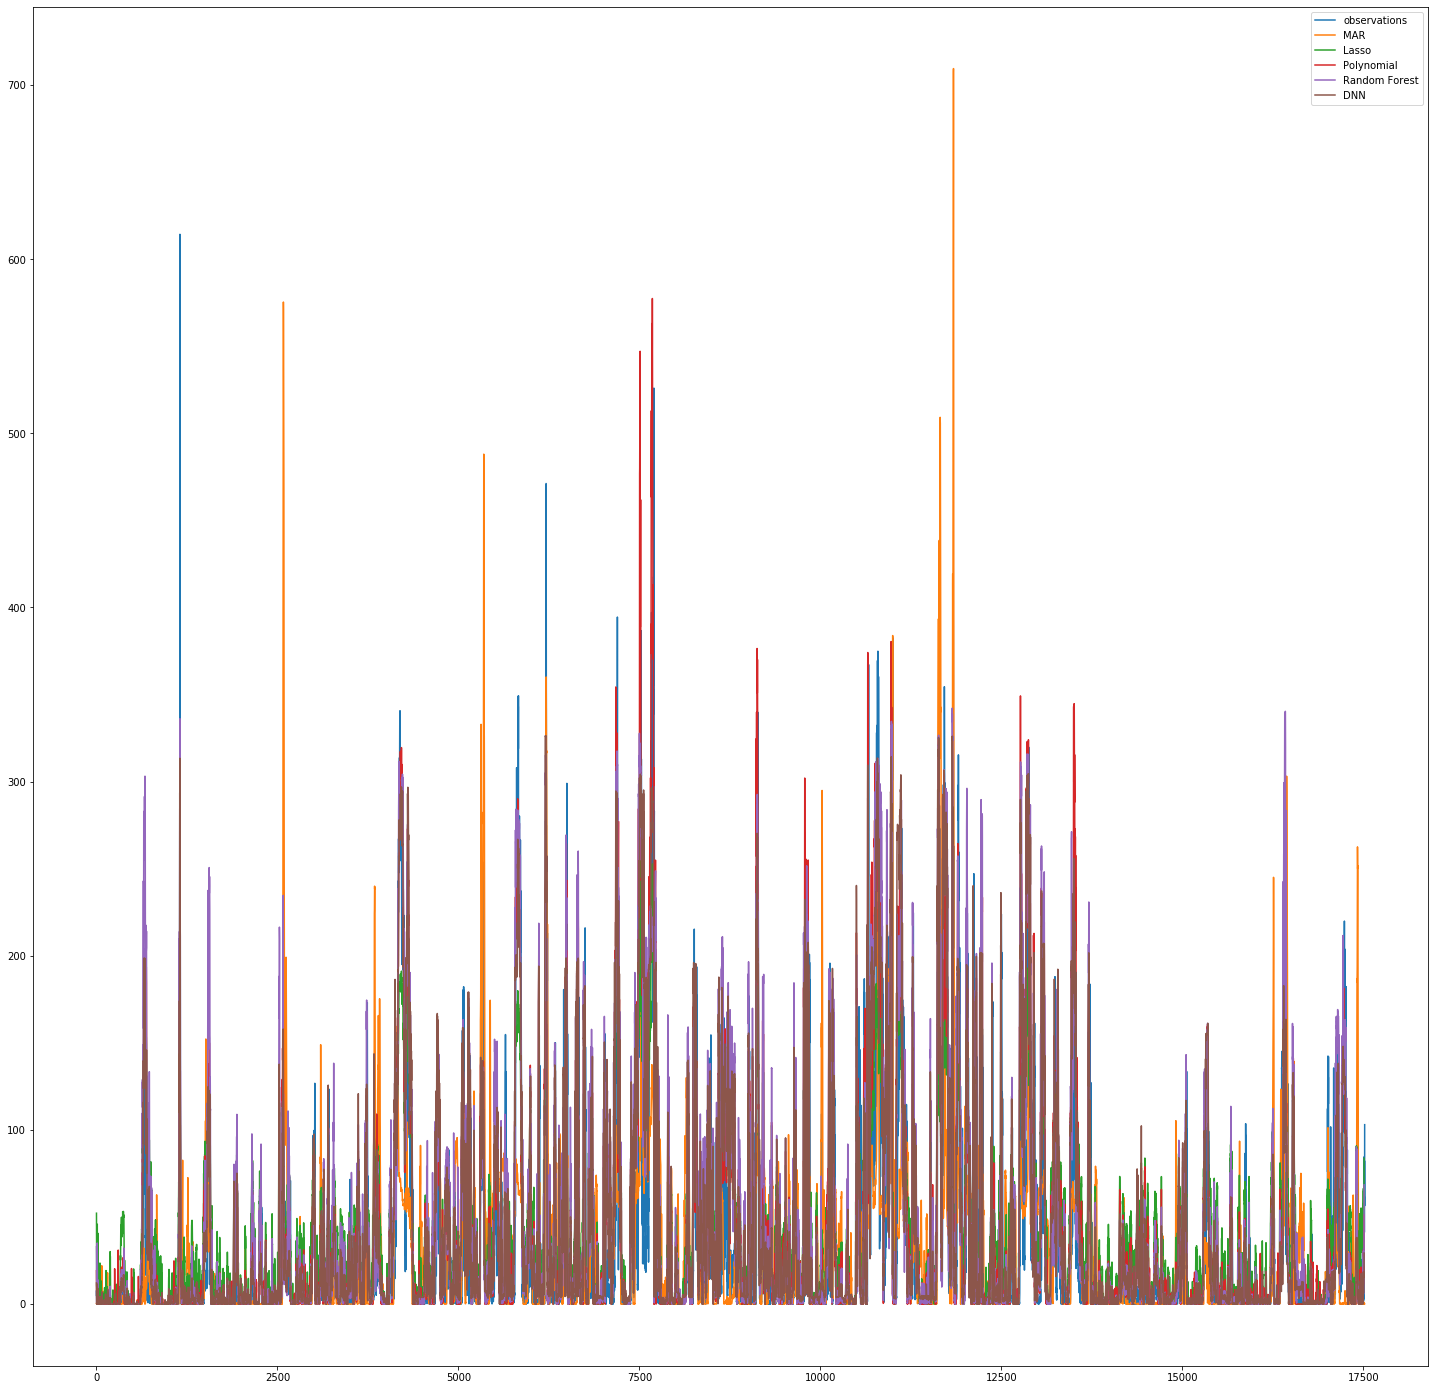

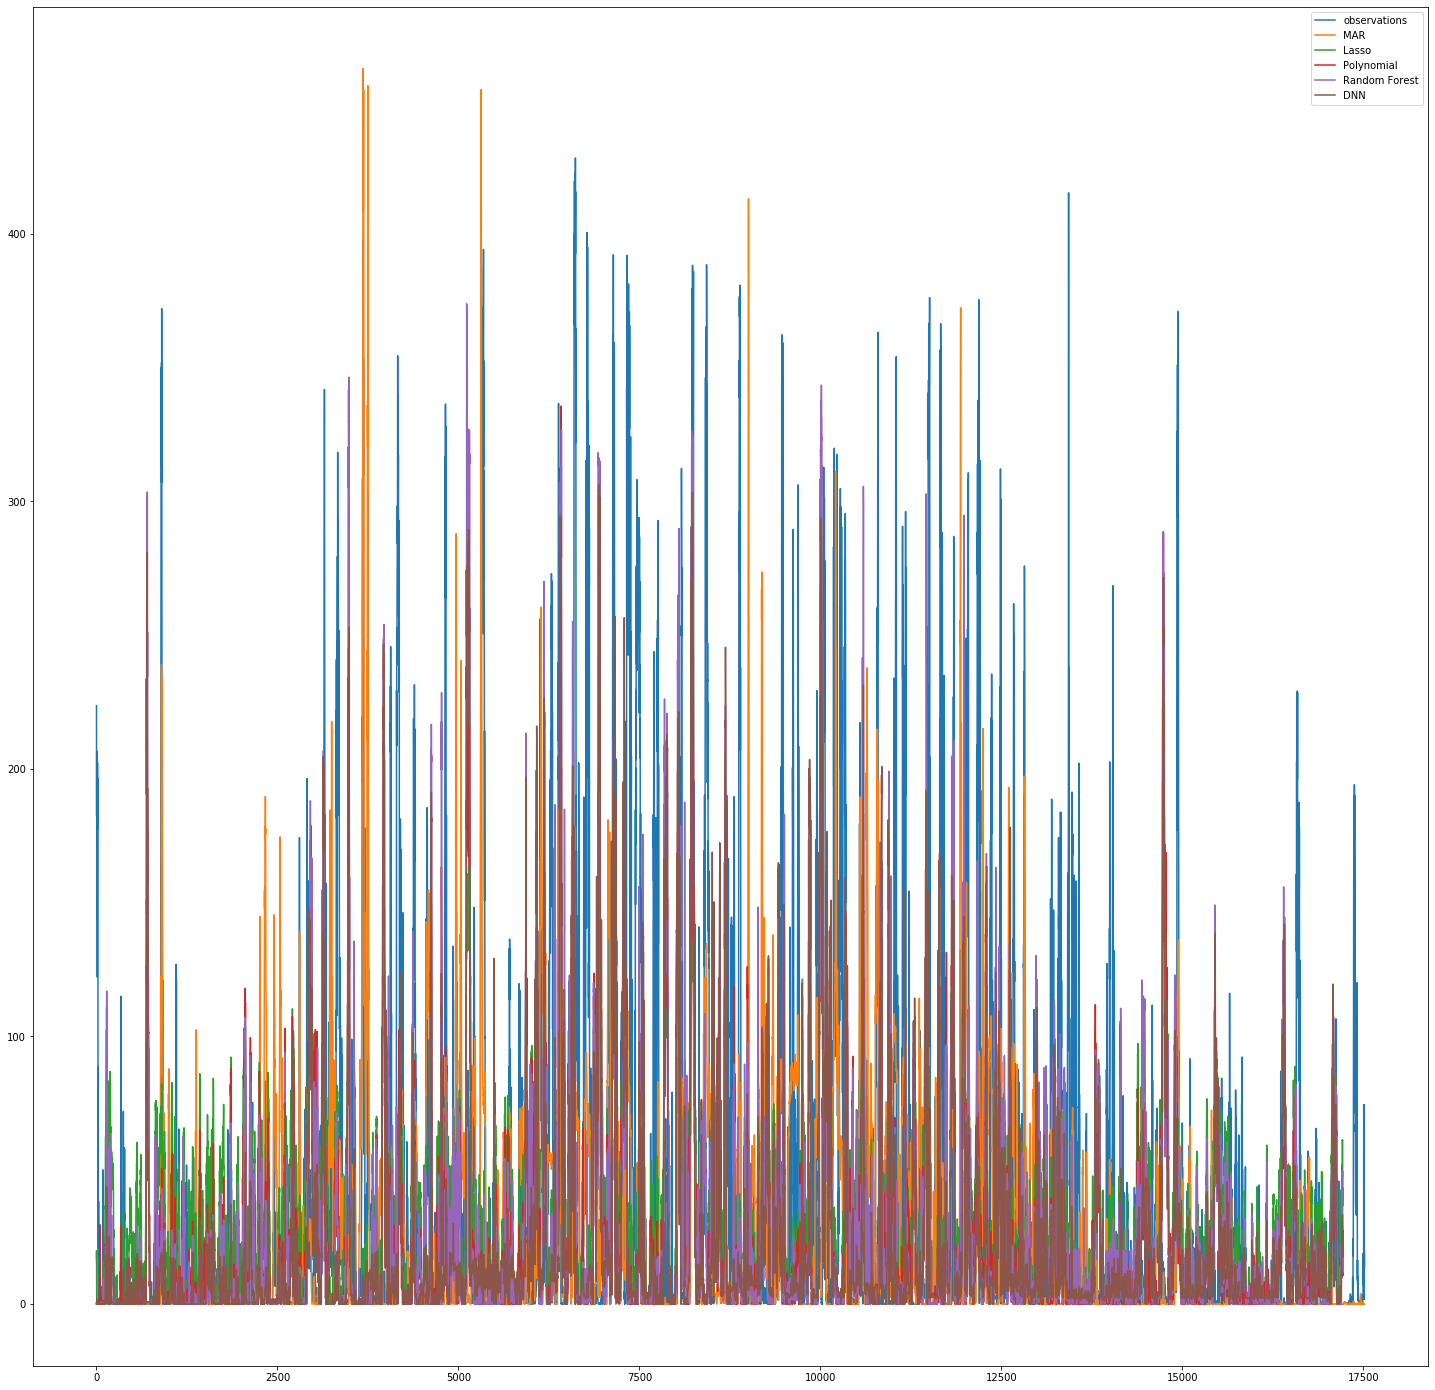

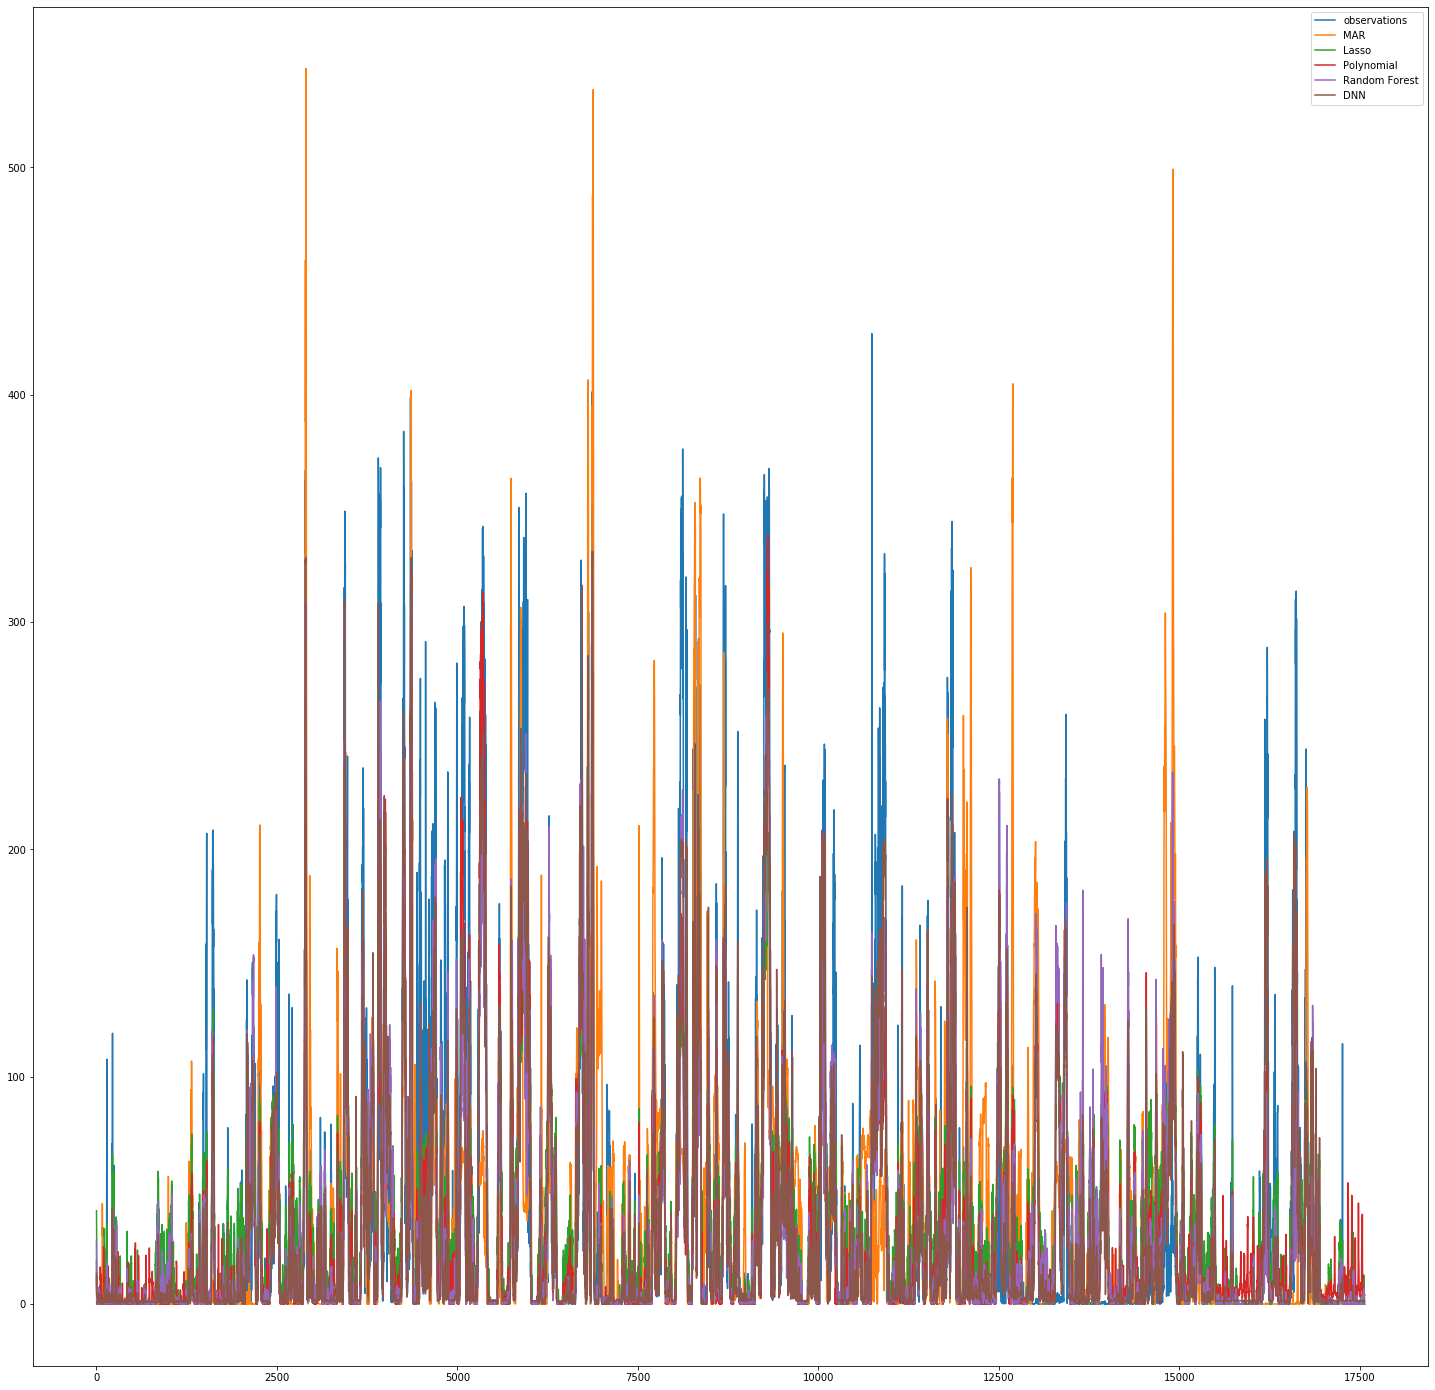

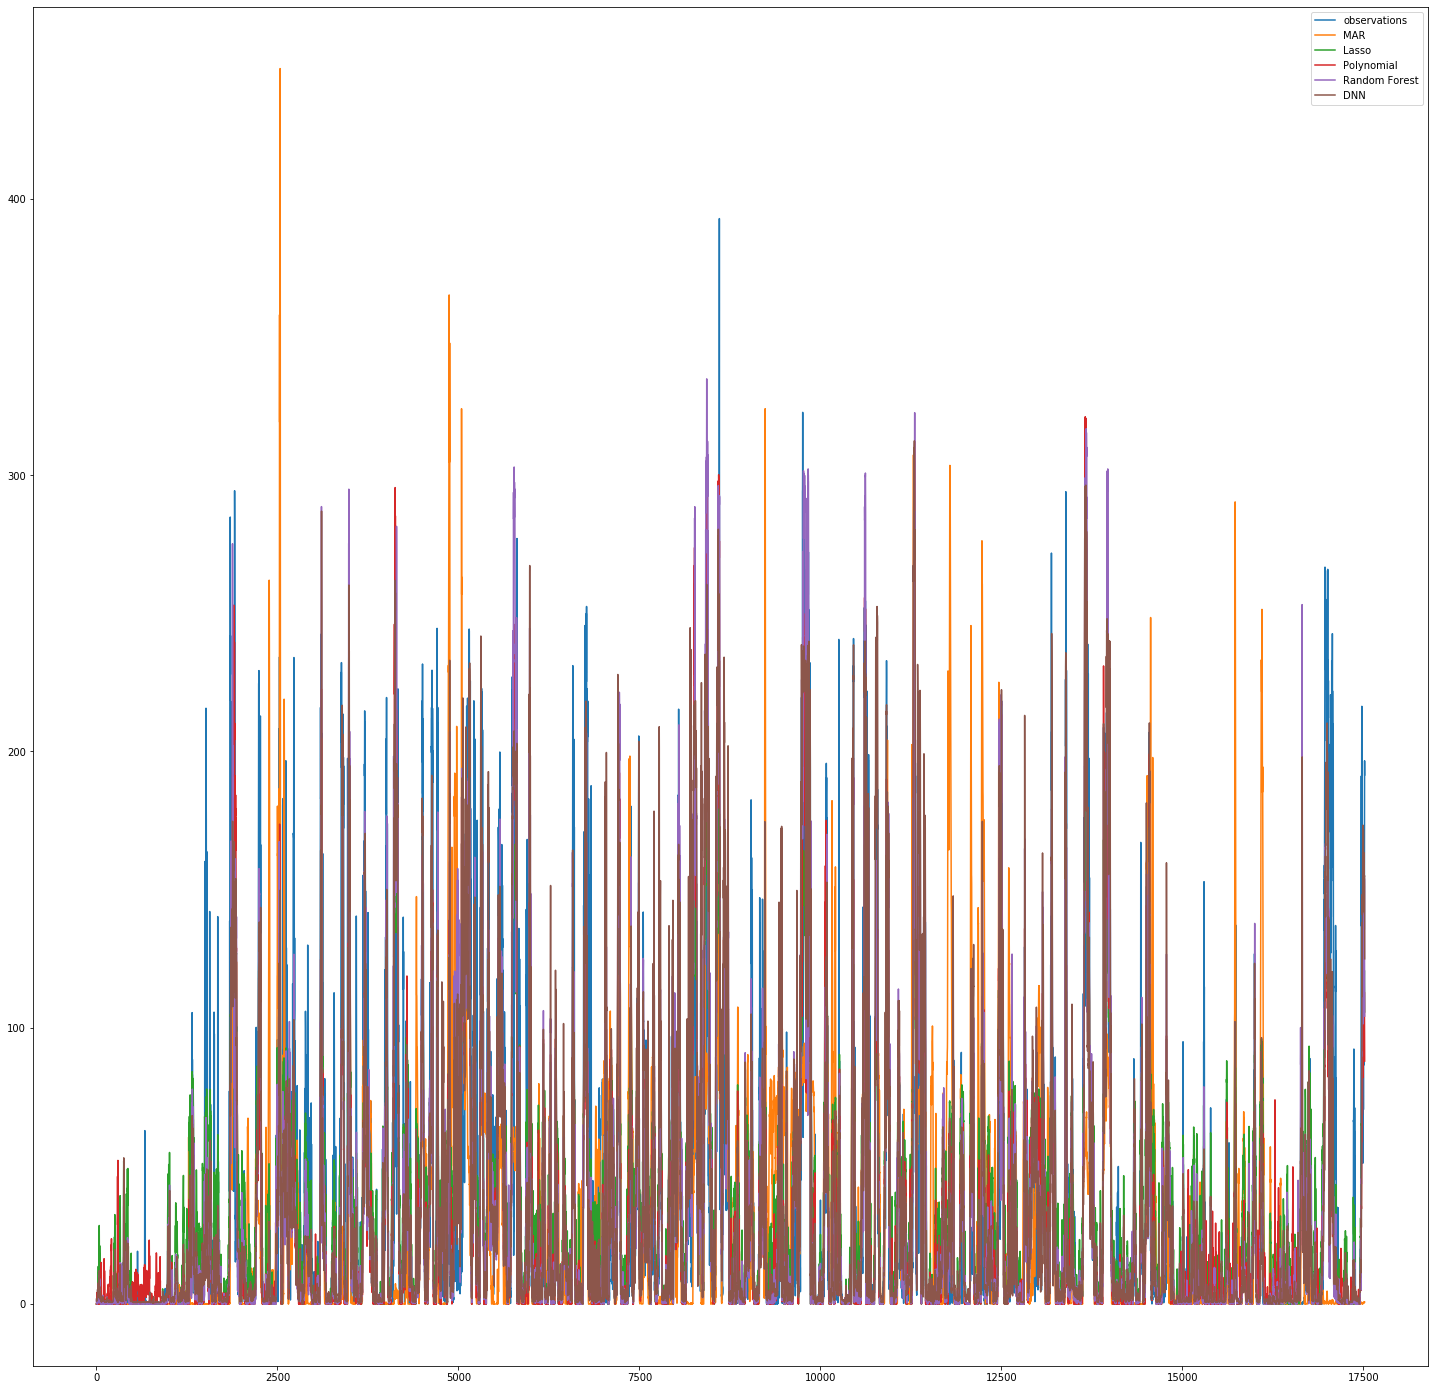

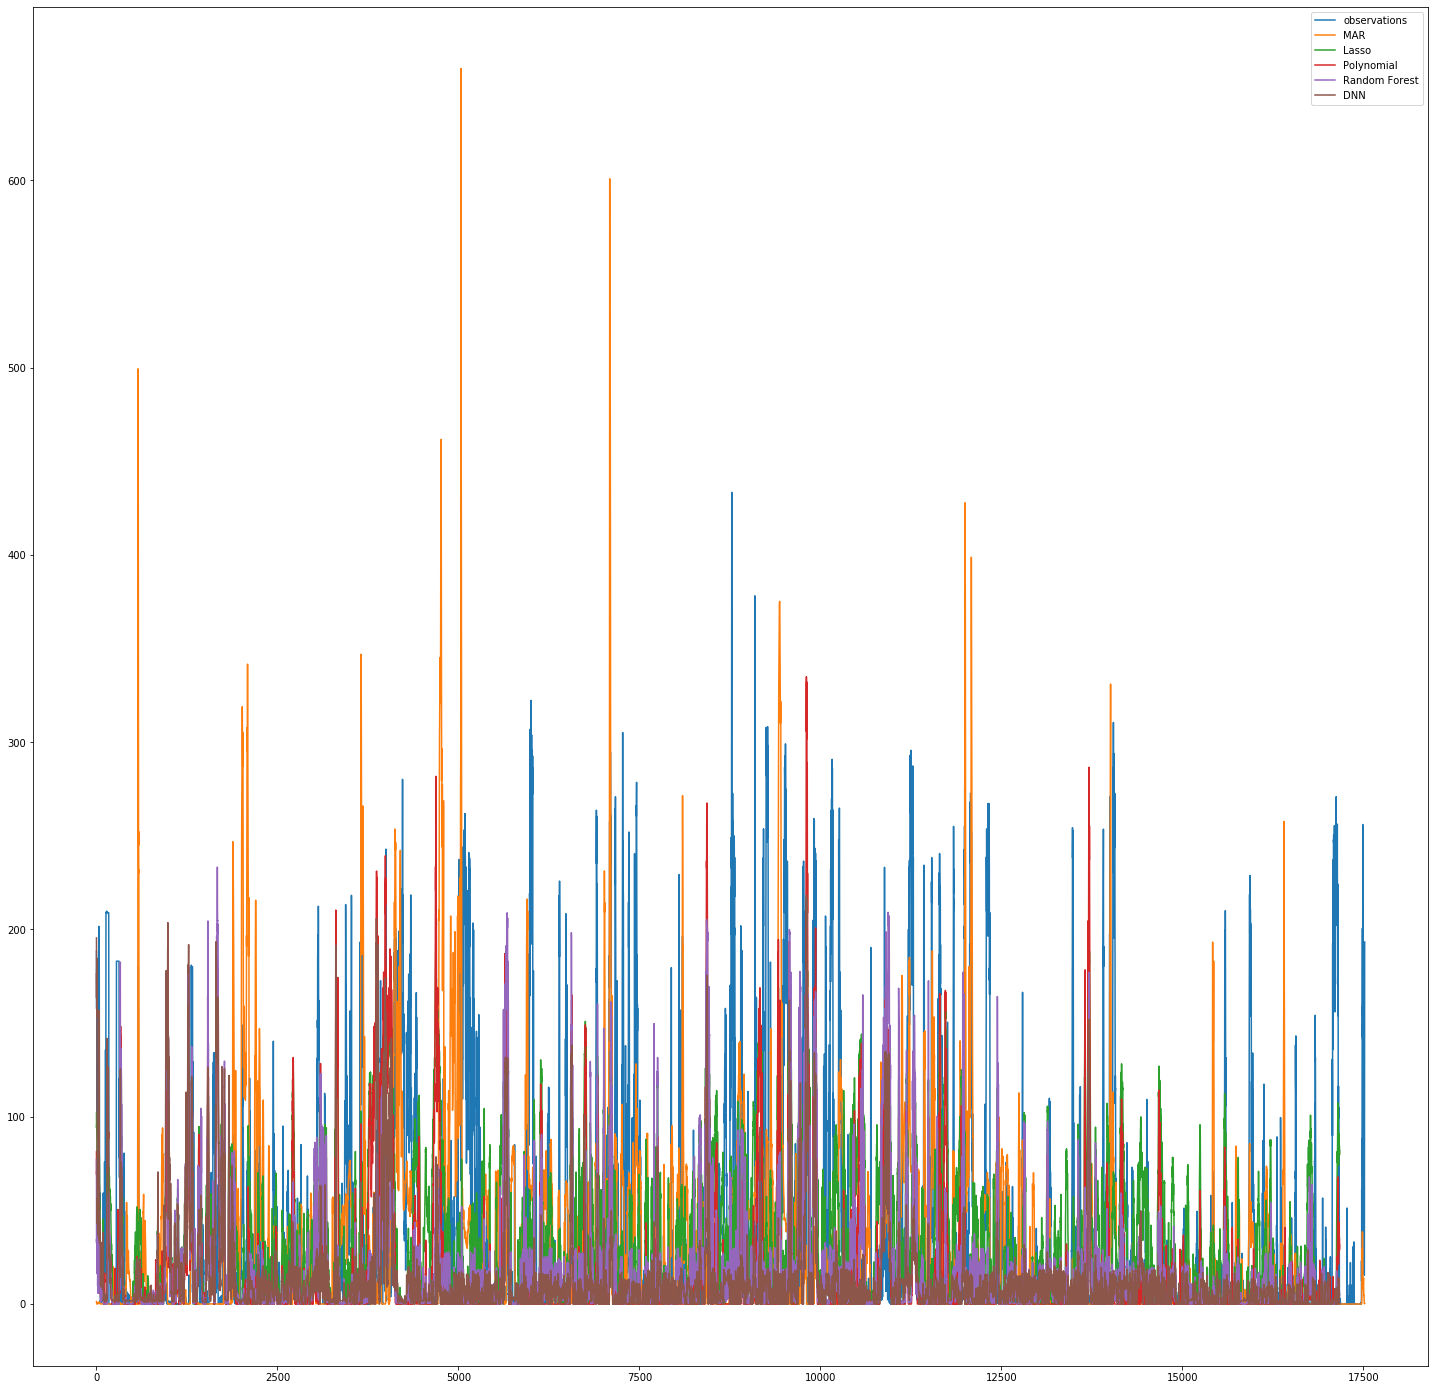

In [0]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
  plt.figure(figsize=(25,25))
  ax = plt.gca()

  observation = D17_observations['FC_2'][(D17_observations.index.year == year)]
  mar_model = MAR['FC'][(MAR.index.year == year)]
  plt.plot(observation.values, label='observations')
  plt.plot(mar_model.values, label='MAR')

  for k in range(number_model-1):
    model = list_y_pred[k][i]
    
    plt.plot(model, label=list_model[k])
    
    ax.legend()

  i = i + 1

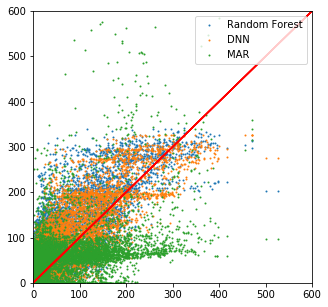

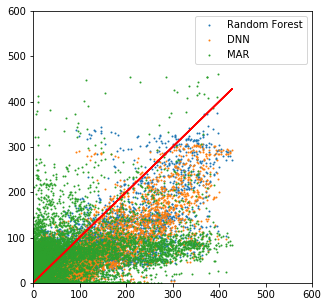

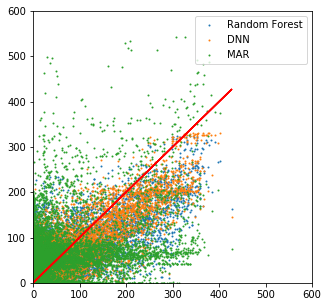

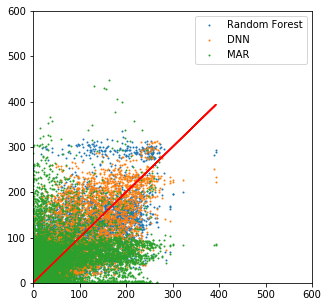

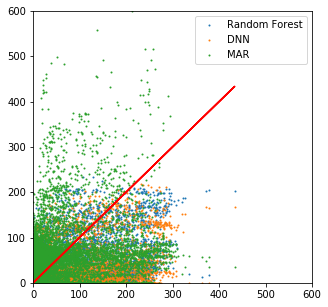

In [0]:
list_model = ['Lasso', 'Polynomial', 'Random Forest', 'DNN', 'MAR']
number_model = len(list_model)
list_year = [2013,2015,2016,2017,2018]
i = 0

for year in list_year:
  plt.figure(figsize=(5,5))
  ax = plt.gca()

  observation = D17_observations['FC_2'][(D17_observations.index.year == year) & (D17_observations.index.isin(list_index[i]))]
  mar_model = MAR['FC'][(MAR.index.year == year) & (MAR.index.isin(list_index[i]))]

  for k in range(2, number_model-1):
    model = list_y_pred[k][i]
    plt.scatter(observation.values, model, s=1, label=list_model[k])
    plt.plot(observation, observation, color='red')
    plt.xlim(0,600)
    plt.ylim(0,600)

  
  plt.scatter(observation.values, mar_model.values, s=1, label='MAR')
  ax.legend()
  
  i = i + 1

In [0]:
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)


In [0]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6120174406772302311
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 17177892759976271725
physical_device_desc: "device: XLA_CPU device"
]


In [0]:
!nvidia-smi

In [0]:
tf.test.gpu_device_name()

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


In [0]:
%tensorflow_version 2.x
import tensorflow as tf